# 파이썬으로 만드는 인공지능(2021, 오일석, 이진선 지음)

# Chapter 8 시계열 데이터와 순환 신경망 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD,Adam,Adagrad,RMSprop
from sklearn.model_selection import KFold
import tensorflow.keras.datasets as ds
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
import numpy as np
from numpy import mean, absolute
import pandas as pd
from scipy import stats
from scipy.stats import iqr
from scipy.stats.mstats import winsorize
import math
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm       # matplotlib color map
import seaborn as sns
from IPython.display import Image
%matplotlib inline

In [2]:
# 텐서플로우 불러오기, 버전 확인
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

<br>

# 8.1 시계열 데이터의 이해

### 8.1.3 시계열 데이터 사례: 비트코인 가격

디지털 통화에 관한 뉴스 사이트 코인데스크(https://www.coindesk.com)에서 비트코인 데이터를 다운로드하자. 코인데스크에 접속해 [Bitcoin 24h]를 선택하면 나타나는 화면에서 기간을 지정하고 (EXPORT DATA) 버튼을 클릭한 후 그 아래에 나타나는 <CSV> 버튼을 클릭해 파일을 다운로드한다. 여기서는 시작 날짜과 끝 날짜를 2019년 2월 28일과 2020년 2월 28일로 설정해 1 년치 데이터를 다운로드했다. 

### 프로그램 8-1(a): 비트코인 가격 데이터 읽기

데이터 길이: 365 
앞쪽 5개 값: [[3772.93633533]
 [3799.67854295]
 [3811.61197937]
 [3804.41917011]
 [3782.66410112]]


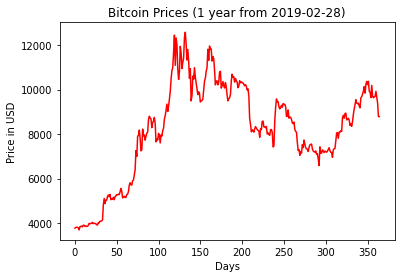

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 다운로드한 1년치 비트코인 가격 데이터 읽기
f=open('D:/00000000000000000000000000000000000000000000000 2022년 고교 서머스쿨/ch8/BTC_USD_2019-02-28_2020-02-27-CoinDesk.csv','r')
coindesk_data=pd.read_csv(f,header=0)
seq=coindesk_data[['Closing Price (USD)']].to_numpy() # 종가만 취함
print('데이터 길이:',len(seq),'\n앞쪽 5개 값:',seq[0:5])

# 그래프로 데이터 확인
plt.plot(seq,color='red')
plt.title('Bitcoin Prices (1 year from 2019-02-28)')
plt.xlabel('Days');plt.ylabel('Price in USD')
plt.show()

In [3]:
BTC = pd.read_csv('D:/00000000000000000000000000000000000000000000000 2022년 고교 서머스쿨/ch8/BTC_USD_2019-02-28_2020-02-27-CoinDesk.csv')
BTC

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048
...,...,...,...,...,...,...
360,BTC,2020-02-24,9919.551448,9689.085992,10008.540472,9666.519497
361,BTC,2020-02-25,9640.469505,9921.048562,10008.378491,9480.185942
362,BTC,2020-02-26,9392.869629,9640.468562,9679.595090,9251.115834
363,BTC,2020-02-27,8787.978363,9392.868579,9393.864137,8626.935746


In [5]:
BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             365 non-null    object 
 1   Date                 365 non-null    object 
 2   Closing Price (USD)  365 non-null    float64
 3   24h Open (USD)       365 non-null    float64
 4   24h High (USD)       365 non-null    float64
 5   24h Low (USD)        365 non-null    float64
dtypes: float64(4), object(2)
memory usage: 17.2+ KB


In [4]:
BTC.dtypes#데이터 타입

Currency                object
Date                    object
Closing Price (USD)    float64
24h Open (USD)         float64
24h High (USD)         float64
24h Low (USD)          float64
dtype: object

In [10]:
BTC.columns#컬럼 이름

Index(['Currency', 'Date', 'Closing Price (USD)', '24h Open (USD)',
       '24h High (USD)', '24h Low (USD)'],
      dtype='object')

In [6]:
BTC.head()#0~4까지

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048


In [7]:
BTC.tail()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
360,BTC,2020-02-24,9919.551448,9689.085992,10008.540472,9666.519497
361,BTC,2020-02-25,9640.469505,9921.048562,10008.378491,9480.185942
362,BTC,2020-02-26,9392.869629,9640.468562,9679.595090,9251.115834
363,BTC,2020-02-27,8787.978363,9392.868579,9393.864137,8626.935746
364,BTC,2020-02-28,8784.995352,8790.336853,8977.585565,8530.496379


In [9]:
BTC.shape# 차원 확인(행,열)

(365, 6)

**열 데이터 추출하기**

In [16]:
# 하나의 열 추출하기
BTC['Closing Price (USD)'

0      3772.936335
1      3799.678543
2      3811.611979
3      3804.419170
4      3782.664101
          ...     
360    9919.551448
361    9640.469505
362    9392.869629
363    8787.978363
364    8784.995352
Name: Closing Price (USD), Length: 365, dtype: float64

In [17]:
# 복수 개의 열 추출하기
BTC[['Closing Price (USD)', '24h Open (USD)']]

,Closing Price (USD),24h Open (USD)
0,3772.936335,3796.637284
1,3799.678543,3773.441461
2,3811.611979,3799.367026
3,3804.419170,3806.691513
4,3782.664101,3807.845756
...,...,...
360,9919.551448,9689.085992
361,9640.469505,9921.048562
362,9392.869629,9640.468562
363,8787.978363,9392.868579


**행 데이터 추출하기**

* loc[]: 인덱스(index)를 기준으로 행 데이터를 추출함
* iloc[]: 행 번호를 기준으로 행 데이터를 추출함

In [24]:
BTC

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048
...,...,...,...,...,...,...
360,BTC,2020-02-24,9919.551448,9689.085992,10008.540472,9666.519497
361,BTC,2020-02-25,9640.469505,9921.048562,10008.378491,9480.185942
362,BTC,2020-02-26,9392.869629,9640.468562,9679.595090,9251.115834
363,BTC,2020-02-27,8787.978363,9392.868579,9393.864137,8626.935746


위의 데이터프레임에서 왼쪽에 번호가 있는 데 이것이 인덱스이다. 인덱스는 별도로 설정하지 않으면 0부터 시작한다. 행 추가, 삭제에 따라 언제든지 변경이 된다. 반면 행 번호의 경우는 데이터프레임에 출력되지 않으며 행 번호란 문자 그대로 행의 순서를 의미한다.

In [25]:
# 첫 번째 행
BTC.loc[0]

Currency                       BTC
Date                    2019-02-28
Closing Price (USD)    3772.936335
24h Open (USD)         3796.637284
24h High (USD)         3824.165879
24h Low (USD)          3666.524016
Name: 0, dtype: object

In [20]:
# 첫 번째 행
BTC.iloc[0]

Currency                       BTC
Date                    2019-02-28
Closing Price (USD)    3772.936335
24h Open (USD)         3796.637284
24h High (USD)         3824.165879
24h Low (USD)          3666.524016
Name: 0, dtype: object

In [12]:
# 첫 번째, 네 번째, 일곱 번째, 열 번째 행
BTC.loc[[0, 3, 6, 9]]

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
6,BTC,2019-03-06,3832.080885,3701.049871,3866.718704,3688.697154
9,BTC,2019-03-09,3828.371904,3859.800616,3917.997566,3778.516481


In [21]:
# 첫 번째, 네 번째, 일곱 번째, 열 번째 행
BTC.iloc[[0, 3, 6, 9]]

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
6,BTC,2019-03-06,3832.080885,3701.049871,3866.718704,3688.697154
9,BTC,2019-03-09,3828.371904,3859.800616,3917.997566,3778.516481


In [15]:
BTC.loc[0:4]   # BTC.loc[0:4] == BTC.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048


In [13]:
BTC.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048


In [23]:
BTC.iloc[0:5]    # cf. BTC.loc[0:4]

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2019-02-28,3772.936335,3796.637284,3824.165879,3666.524016
1,BTC,2019-03-01,3799.678543,3773.441461,3879.231185,3753.800022
2,BTC,2019-03-02,3811.611979,3799.367026,3840.044823,3788.918498
3,BTC,2019-03-03,3804.419170,3806.691513,3819.194356,3759.409216
4,BTC,2019-03-04,3782.664101,3807.845756,3818.695481,3766.242048


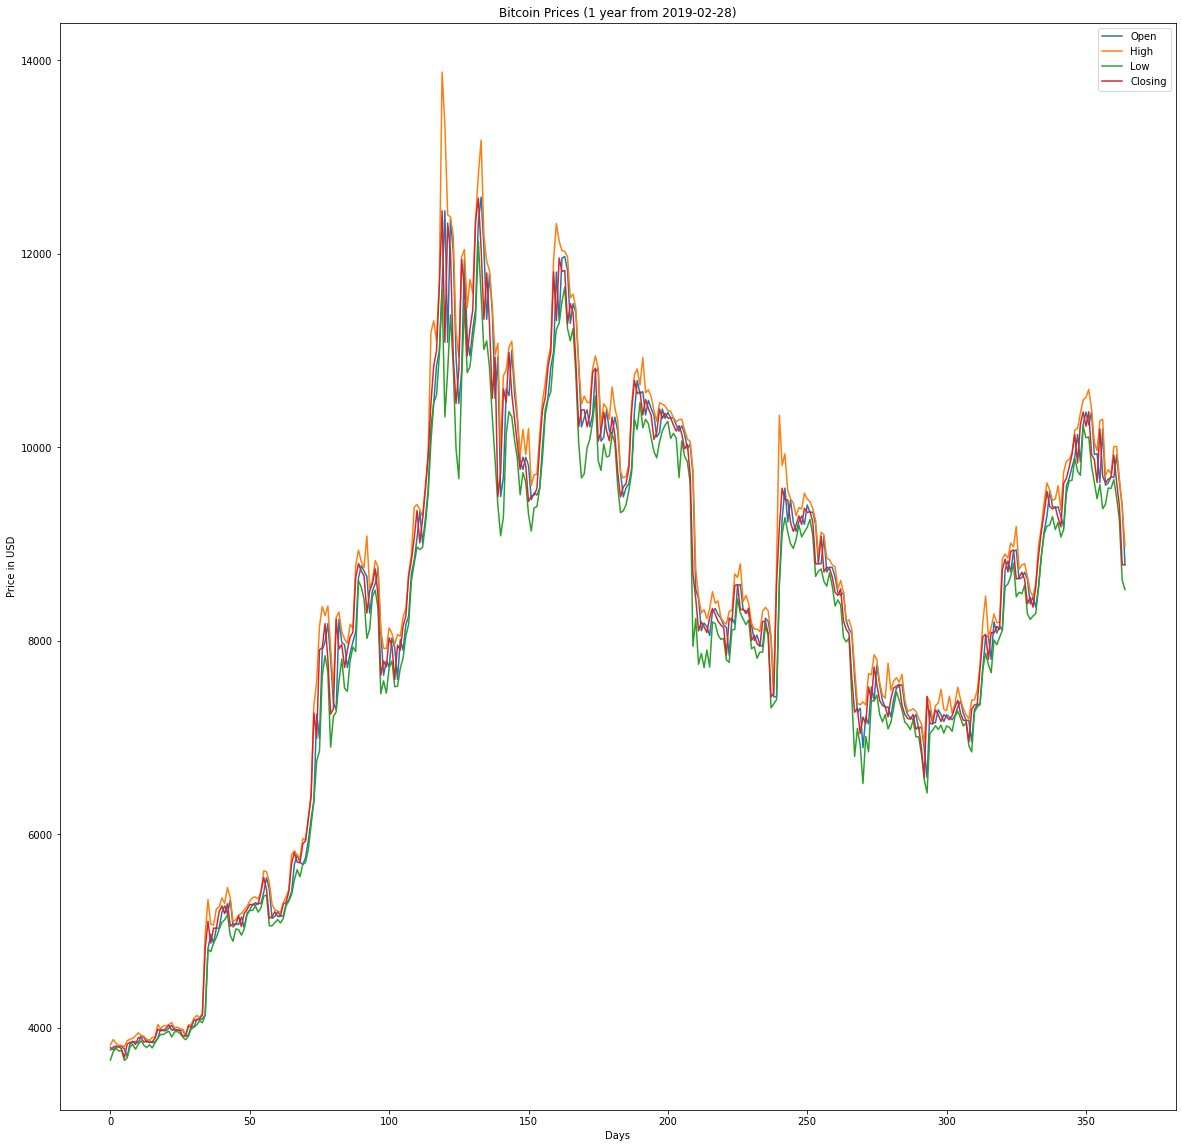

In [22]:
plt.figure(figsize=(20,20))     
plt.plot(BTC['24h Open (USD)'], label='Open')
plt.plot(BTC['24h High (USD)'], label='High')
plt.plot(BTC['24h Low (USD)'], label='Low')
plt.plot(BTC['Closing Price (USD)'], label='Closing')
plt.title('Bitcoin Prices (1 year from 2019-02-28)')
plt.xlabel('Days');plt.ylabel('Price in USD')
plt.legend()#각 색이 의미하는 라벨 (파-open,노-high,초-low,빨-closing)
plt.show()

In [23]:
BTC.describe()
#개수
#평균
#표준편차
#최소
#25%
#50%
#75%
#최대

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
count,365.000000,365.000000,365.000000,365.000000
mean,8198.428937,8181.594957,8393.150021,7963.492136
std,2167.890069,2180.475713,2262.464104,2075.913181
min,3689.862893,3701.049871,3804.353616,3663.477743
25%,7213.733762,7212.808361,7348.789794,7065.278308
50%,8347.567505,8320.168154,8539.132174,8167.264904
75%,9838.900016,9851.644254,10132.404725,9615.263421
max,12575.904067,12585.241974,13879.237706,12127.712182


In [24]:
BTC.describe().T#변수가 많을 때 describe 헹렬 반전

,count,mean,std,min,25%,50%,75%,max
Closing Price (USD),365.0,8198.428937,2167.890069,3689.862893,7213.733762,8347.567505,9838.900016,12575.904067
24h Open (USD),365.0,8181.594957,2180.475713,3701.049871,7212.808361,8320.168154,9851.644254,12585.241974
24h High (USD),365.0,8393.150021,2262.464104,3804.353616,7348.789794,8539.132174,10132.404725,13879.237706
24h Low (USD),365.0,7963.492136,2075.913181,3663.477743,7065.278308,8167.264904,9615.263421,12127.712182


In [25]:
BTC.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Closing Price (USD),365.0,8198.428937,2167.890069,3689.862893,7213.733762,8347.567505,9838.900016,12575.904067
24h Open (USD),365.0,8181.594957,2180.475713,3701.049871,7212.808361,8320.168154,9851.644254,12585.241974
24h High (USD),365.0,8393.150021,2262.464104,3804.353616,7348.789794,8539.132174,10132.404725,13879.237706
24h Low (USD),365.0,7963.492136,2075.913181,3663.477743,7065.278308,8167.264904,9615.263421,12127.712182


In [26]:
BTC['Closing Price (USD)']

0      3772.936335
1      3799.678543
2      3811.611979
3      3804.419170
4      3782.664101
          ...     
360    9919.551448
361    9640.469505
362    9392.869629
363    8787.978363
364    8784.995352
Name: Closing Price (USD), Length: 365, dtype: float64

In [48]:
BTC['Closing Price (USD)'].sum()#합

2992426.5618442046

In [49]:
BTC['Closing Price (USD)'].cumsum()#누적

0      3.772936e+03
1      7.572615e+03
2      1.138423e+04
3      1.518865e+04
4      1.897131e+04
           ...     
360    2.955820e+06
361    2.965461e+06
362    2.974854e+06
363    2.983642e+06
364    2.992427e+06
Name: Closing Price (USD), Length: 365, dtype: float64

* Python에서 ECDF plot를 만드는 방법

Method 1 – Using custom functions

In [50]:
# ECDF function to generate x and y axis data
def ecdf(xdata):
    xdataecdf = np.sort(xdata)
    ydataecdf = np.arange(1, len(xdata) + 1) / len(xdata)
    return xdataecdf, ydataecdf

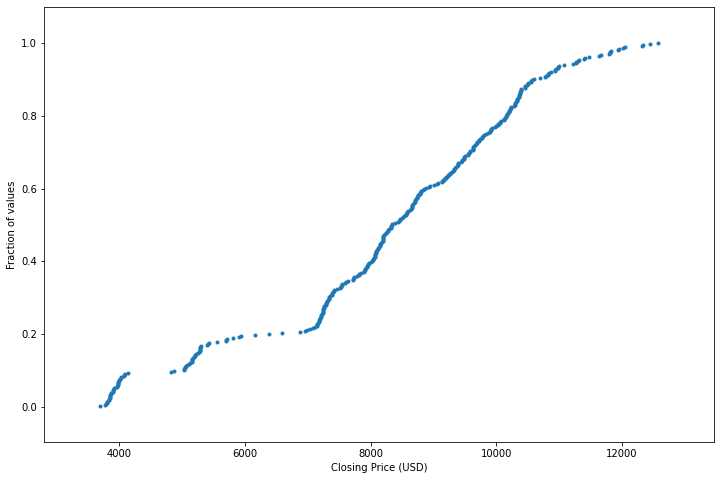

In [54]:
# Get the x and y data for ecdf plot from ecdf method 경험적누적분포함수(분위수)
x,y = ecdf(BTC['Closing Price (USD)'])
 
# Plot the data using matplotlib
plt.figure(figsize=(12,8))  
plt.plot(x, y, marker = '.', linestyle = 'none')
plt.xlabel('Closing Price (USD)')
plt.ylabel('Fraction of values')
plt.margins(0.1)

Method 2 – Using Seaborn library

<br>

* sns.ecdfplot(): Plot empirical cumulative distribution functions.

```
Signature:
sns.ecdfplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='proportion',
    complementary=False,
    palette=None,
    hue_order=None,
    hue_norm=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot empirical cumulative distribution functions.

An ECDF represents the proportion or count of observations falling below each
unique value in a dataset. Compared to a histogram or density plot, it has the
advantage that each observation is visualized directly, meaning that there are
no binning or smoothing parameters that need to be adjusted. It also aids direct
comparisons between multiple distributions. A downside is that the relationship
between the appearance of the plot and the basic properties of the distribution
(such as its central tendency, variance, and the presence of any bimodality)
may not be as intuitive.

More information is provided in the :ref:`user guide <tutorial_ecdf>`.

Parameters
----------
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color of plot elements.
weights : vector or key in ``data``
    If provided, weight the contribution of the corresponding data points
    towards the cumulative distribution using these values.
stat : {{"proportion", "count"}}
    Distribution statistic to compute.
complementary : bool
    If True, use the complementary CDF (1 - CDF)
palette : string, list, dict, or :class:`matplotlib.colors.Colormap`
    Method for choosing the colors to use when mapping the ``hue`` semantic.
    String values are passed to :func:`color_palette`. List or dict values
    imply categorical mapping, while a colormap object implies numeric mapping.
hue_order : vector of strings
    Specify the order of processing and plotting for categorical levels of the
    ``hue`` semantic.
hue_norm : tuple or :class:`matplotlib.colors.Normalize`
    Either a pair of values that set the normalization range in data units
    or an object that will map from data units into a [0, 1] interval. Usage
    implies numeric mapping.
log_scale : bool or number, or pair of bools or numbers
    Set a log scale on the data axis (or axes, with bivariate data) with the
    given base (default 10), and evaluate the KDE in log space.
legend : bool
    If False, suppress the legend for semantic variables.
ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the plot. Otherwise, call :func:`matplotlib.pyplot.gca`
    internally.
kwargs
    Other keyword arguments are passed to :meth:`matplotlib.axes.Axes.plot`.

Returns
-------
:class:`matplotlib.axes.Axes`
    The matplotlib axes containing the plot.

See Also
--------
displot : Figure-level interface to distribution plot functions.
histplot : Plot a histogram of binned counts with optional normalization or smoothing.
kdeplot : Plot univariate or bivariate distributions using kernel density estimation.
rugplot : Plot a tick at each observation value along the x and/or y axes.

Examples
--------

.. include:: ../docstrings/ecdfplot.rst
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\distributions.py
Type:      function
```

<br>

<AxesSubplot:xlabel='Closing Price (USD)', ylabel='Proportion'>

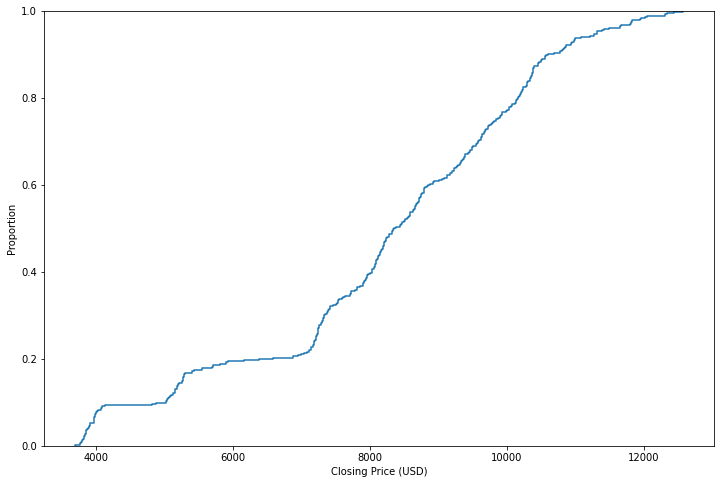

In [57]:
import seaborn as sns

plt.figure(figsize=(12,8))  
# step function 계단함수
sns.ecdfplot(x = BTC['Closing Price (USD)'])

* sns.distplot(): DEPRECATED: Flexibly plot a univariate distribution of observations.

<br>

```
Signature:
sns.distplot(
    a=None,
    bins=None,
    hist=True,
    kde=True,
    rug=False,
    fit=None,
    hist_kws=None,
    kde_kws=None,
    rug_kws=None,
    fit_kws=None,
    color=None,
    vertical=False,
    norm_hist=False,
    axlabel=None,
    label=None,
    ax=None,
    x=None,
)
Docstring:
DEPRECATED: Flexibly plot a univariate distribution of observations.

.. warning::
   This function is deprecated and will be removed in a future version.
   Please adapt your code to use one of two new functions:

   - :func:`displot`, a figure-level function with a similar flexibility
     over the kind of plot to draw
   - :func:`histplot`, an axes-level function for plotting histograms,
     including with kernel density smoothing

This function combines the matplotlib ``hist`` function (with automatic
calculation of a good default bin size) with the seaborn :func:`kdeplot`
and :func:`rugplot` functions. It can also fit ``scipy.stats``
distributions and plot the estimated PDF over the data.

Parameters
----------
a : Series, 1d-array, or list.
    Observed data. If this is a Series object with a ``name`` attribute,
    the name will be used to label the data axis.
bins : argument for matplotlib hist(), or None, optional
    Specification of hist bins. If unspecified, as reference rule is used
    that tries to find a useful default.
hist : bool, optional
    Whether to plot a (normed) histogram.
kde : bool, optional
    Whether to plot a gaussian kernel density estimate.
rug : bool, optional
    Whether to draw a rugplot on the support axis.
fit : random variable object, optional
    An object with `fit` method, returning a tuple that can be passed to a
    `pdf` method a positional arguments following a grid of values to
    evaluate the pdf on.
hist_kws : dict, optional
    Keyword arguments for :meth:`matplotlib.axes.Axes.hist`.
kde_kws : dict, optional
    Keyword arguments for :func:`kdeplot`.
rug_kws : dict, optional
    Keyword arguments for :func:`rugplot`.
color : matplotlib color, optional
    Color to plot everything but the fitted curve in.
vertical : bool, optional
    If True, observed values are on y-axis.
norm_hist : bool, optional
    If True, the histogram height shows a density rather than a count.
    This is implied if a KDE or fitted density is plotted.
axlabel : string, False, or None, optional
    Name for the support axis label. If None, will try to get it
    from a.name if False, do not set a label.
label : string, optional
    Legend label for the relevant component of the plot.
ax : matplotlib axis, optional
    If provided, plot on this axis.

Returns
-------
ax : matplotlib Axes
    Returns the Axes object with the plot for further tweaking.

See Also
--------
kdeplot : Show a univariate or bivariate distribution with a kernel
          density estimate.
rugplot : Draw small vertical lines to show each observation in a
          distribution.

Examples
--------

Show a default plot with a kernel density estimate and histogram with bin
size determined automatically with a reference rule:

.. plot::
    :context: close-figs

    >>> import seaborn as sns, numpy as np
    >>> sns.set_theme(); np.random.seed(0)
    >>> x = np.random.randn(100)
    >>> ax = sns.distplot(x)

Use Pandas objects to get an informative axis label:

.. plot::
    :context: close-figs

    >>> import pandas as pd
    >>> x = pd.Series(x, name="x variable")
    >>> ax = sns.distplot(x)

Plot the distribution with a kernel density estimate and rug plot:

.. plot::
    :context: close-figs

    >>> ax = sns.distplot(x, rug=True, hist=False)

Plot the distribution with a histogram and maximum likelihood gaussian
distribution fit:

.. plot::
    :context: close-figs

    >>> from scipy.stats import norm
    >>> ax = sns.distplot(x, fit=norm, kde=False)

Plot the distribution on the vertical axis:

.. plot::
    :context: close-figs

    >>> ax = sns.distplot(x, vertical=True)

Change the color of all the plot elements:

.. plot::
    :context: close-figs

    >>> sns.set_color_codes()
    >>> ax = sns.distplot(x, color="y")

Pass specific parameters to the underlying plot functions:

.. plot::
    :context: close-figs

    >>> ax = sns.distplot(x, rug=True, rug_kws={"color": "g"},
    ...                   kde_kws={"color": "k", "lw": 3, "label": "KDE"},
    ...                   hist_kws={"histtype": "step", "linewidth": 3,
    ...                             "alpha": 1, "color": "g"})
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\distributions.py
Type:      function
```

<br>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


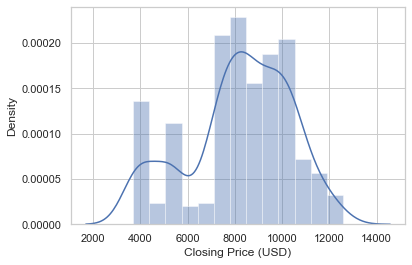

In [66]:
sns.set_theme(style="whitegrid")
ax = sns.distplot(BTC['Closing Price (USD)']) #히스토그램+커널밀도

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


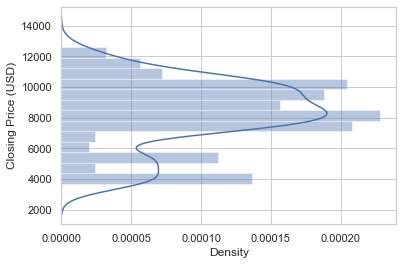

In [93]:
sns.set_theme(style="whitegrid")
ax = sns.distplot(BTC['Closing Price (USD)'], vertical=True)

* sns.histplot(): Plot univariate or bivariate histograms to show distributions of datasets.
    
<br>

```
Signature:
sns.histplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='count',
    bins='auto',
    binwidth=None,
    binrange=None,
    discrete=None,
    cumulative=False,
    common_bins=True,
    common_norm=True,
    multiple='layer',
    element='bars',
    fill=True,
    shrink=1,
    kde=False,
    kde_kws=None,
    line_kws=None,
    thresh=0,
    pthresh=None,
    pmax=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
disrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mass, and it can add a smooth curve obtained
using a kernel density estimate, similar to :func:`kdeplot`.

More information is provided in the :ref:`user guide <tutorial_hist>`.

Parameters
----------
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color of plot elements.
weights : vector or key in ``data``
    If provided, weight the contribution of the corresponding data points
    towards the count in each bin by these factors.
stat : {"count", "frequency", "density", "probability"}
    Aggregate statistic to compute in each bin.
    
    - ``count`` shows the number of observations
    - ``frequency`` shows the number of observations divided by the bin width
    - ``density`` normalizes counts so that the area of the histogram is 1
    - ``probability`` normalizes counts so that the sum of the bar heights is 1
bins : str, number, vector, or a pair of such values
    Generic bin parameter that can be the name of a reference rule,
    the number of bins, or the breaks of the bins.
    Passed to :func:`numpy.histogram_bin_edges`.
binwidth : number or pair of numbers
    Width of each bin, overrides ``bins`` but can be used with
    ``binrange``.
binrange : pair of numbers or a pair of pairs
    Lowest and highest value for bin edges; can be used either
    with ``bins`` or ``binwidth``. Defaults to data extremes.
discrete : bool
    If True, default to ``binwidth=1`` and draw the bars so that they are
    centered on their corresponding data points. This avoids "gaps" that may
    otherwise appear when using discrete (integer) data.
cumulative : bool
    If True, plot the cumulative counts as bins increase.
common_bins : bool
    If True, use the same bins when semantic variables produce multiple
    plots. If using a reference rule to determine the bins, it will be computed
    with the full dataset.
common_norm : bool
    If True and using a normalized statistic, the normalization will apply over
    the full dataset. Otherwise, normalize each histogram independently.
multiple : {"layer", "dodge", "stack", "fill"}
    Approach to resolving multiple elements when semantic mapping creates subsets.
    Only relevant with univariate data.
element : {"bars", "step", "poly"}
    Visual representation of the histogram statistic.
    Only relevant with univariate data.
fill : bool
    If True, fill in the space under the histogram.
    Only relevant with univariate data.
shrink : number
    Scale the width of each bar relative to the binwidth by this factor.
    Only relevant with univariate data.
kde : bool
    If True, compute a kernel density estimate to smooth the distribution
    and show on the plot as (one or more) line(s).
    Only relevant with univariate data.
kde_kws : dict
    Parameters that control the KDE computation, as in :func:`kdeplot`.
line_kws : dict
    Parameters that control the KDE visualization, passed to
    :meth:`matplotlib.axes.Axes.plot`.
thresh : number or None
    Cells with a statistic less than or equal to this value will be transparent.
    Only relevant with bivariate data.
pthresh : number or None
    Like ``thresh``, but a value in [0, 1] such that cells with aggregate counts
    (or other statistics, when used) up to this proportion of the total will be
    transparent.
pmax : number or None
    A value in [0, 1] that sets that saturation point for the colormap at a value
    such that cells below is constistute this proportion of the total count (or
    other statistic, when used).
cbar : bool
    If True, add a colorbar to annotate the color mapping in a bivariate plot.
    Note: Does not currently support plots with a ``hue`` variable well.
cbar_ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the colorbar.
cbar_kws : dict
    Additional parameters passed to :meth:`matplotlib.figure.Figure.colorbar`.
palette : string, list, dict, or :class:`matplotlib.colors.Colormap`
    Method for choosing the colors to use when mapping the ``hue`` semantic.
    String values are passed to :func:`color_palette`. List or dict values
    imply categorical mapping, while a colormap object implies numeric mapping.
hue_order : vector of strings
    Specify the order of processing and plotting for categorical levels of the
    ``hue`` semantic.
hue_norm : tuple or :class:`matplotlib.colors.Normalize`
    Either a pair of values that set the normalization range in data units
    or an object that will map from data units into a [0, 1] interval. Usage
    implies numeric mapping.
color : :mod:`matplotlib color <matplotlib.colors>`
    Single color specification for when hue mapping is not used. Otherwise, the
    plot will try to hook into the matplotlib property cycle.
log_scale : bool or number, or pair of bools or numbers
    Set a log scale on the data axis (or axes, with bivariate data) with the
    given base (default 10), and evaluate the KDE in log space.
legend : bool
    If False, suppress the legend for semantic variables.
ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the plot. Otherwise, call :func:`matplotlib.pyplot.gca`
    internally.
kwargs
    Other keyword arguments are passed to one of the following matplotlib
    functions:

    - :meth:`matplotlib.axes.Axes.bar` (univariate, element="bars")
    - :meth:`matplotlib.axes.Axes.fill_between` (univariate, other element, fill=True)
    - :meth:`matplotlib.axes.Axes.plot` (univariate, other element, fill=False)
    - :meth:`matplotlib.axes.Axes.pcolormesh` (bivariate)

Returns
-------
:class:`matplotlib.axes.Axes`
    The matplotlib axes containing the plot.

See Also
--------
displot : Figure-level interface to distribution plot functions.
kdeplot : Plot univariate or bivariate distributions using kernel density estimation.
rugplot : Plot a tick at each observation value along the x and/or y axes.
ecdfplot : Plot empirical cumulative distribution functions.
jointplot : Draw a bivariate plot with univariate marginal distributions.

Notes
-----

The choice of bins for computing and plotting a histogram can exert
substantial influence on the insights that one is able to draw from the
visualization. If the bins are too large, they may erase important features.
On the other hand, bins that are too small may be dominated by random
variability, obscuring the shape of the true underlying distribution. The
default bin size is determined using a reference rule that depends on the
sample size and variance. This works well in many cases, (i.e., with
"well-behaved" data) but it fails in others. It is always a good to try
different bin sizes to be sure that you are not missing something important.
This function allows you to specify bins in several different ways, such as
by setting the total number of bins to use, the width of each bin, or the
specific locations where the bins should break.

Examples
--------

.. include:: ../docstrings/histplot.rst
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\distributions.py
Type:      function
```

<br>

* sns.rugplot(): Plot marginal distributions by drawing ticks along the x and y axes.

<br>

```
Signature:
sns.rugplot(
    x=None,
    *,
    height=0.025,
    axis=None,
    ax=None,
    data=None,
    y=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    expand_margins=True,
    legend=True,
    a=None,
    **kwargs,
)
Docstring:
Plot marginal distributions by drawing ticks along the x and y axes.

This function is intended to complement other plots by showing the location
of individual observations in an unobstrusive way.

Parameters
----------
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
height : number
    Proportion of axes extent covered by each rug element.
axis : {"x", "y"}
    Axis to draw the rug on.

    .. deprecated:: 0.11.0
       specify axis by assigning the ``x`` or ``y`` variables.

ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the plot. Otherwise, call :func:`matplotlib.pyplot.gca`
    internally.
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color of plot elements.
palette : string, list, dict, or :class:`matplotlib.colors.Colormap`
    Method for choosing the colors to use when mapping the ``hue`` semantic.
    String values are passed to :func:`color_palette`. List or dict values
    imply categorical mapping, while a colormap object implies numeric mapping.
hue_order : vector of strings
    Specify the order of processing and plotting for categorical levels of the
    ``hue`` semantic.
hue_norm : tuple or :class:`matplotlib.colors.Normalize`
    Either a pair of values that set the normalization range in data units
    or an object that will map from data units into a [0, 1] interval. Usage
    implies numeric mapping.
expand_margins : bool
    If True, increase the axes margins by the height of the rug to avoid
    overlap with other elements.
legend : bool
    If False, do not add a legend for semantic variables.
kwargs
    Other keyword arguments are passed to
    :meth:`matplotlib.collections.LineCollection`

Returns
-------
:class:`matplotlib.axes.Axes`
    The matplotlib axes containing the plot.

Examples
--------

.. include:: ../docstrings/rugplot.rst
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\distributions.py
Type:      function
```

<br>

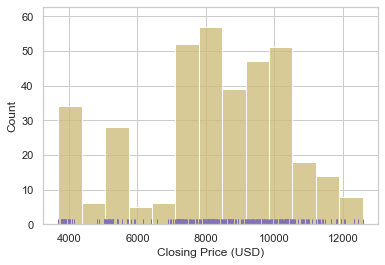

In [79]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(BTC['Closing Price (USD)'], color="y")
ax = sns.rugplot(BTC['Closing Price (USD)'], color="m")

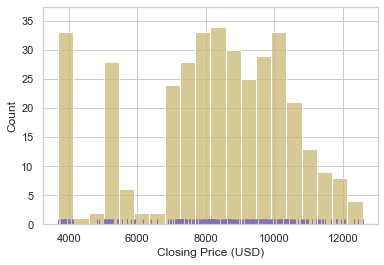

In [94]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(BTC['Closing Price (USD)'], bins=20, color="y") # bins=20: bin 갯수 조정
ax = sns.rugplot(BTC['Closing Price (USD)'], color="m")

* sns.kdeplot(): Plot univariate or bivariate distributions using kernel density estimation.

<br>


```
Signature:
sns.kdeplot(
    x=None,
    *,
    y=None,
    shade=None,
    vertical=False,
    kernel=None,
    bw=None,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    weights=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    levels=10,
    thresh=0.05,
    bw_method='scott',
    bw_adjust=1,
    log_scale=None,
    color=None,
    fill=None,
    data=None,
    data2=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate distributions using kernel density estimation.

A kernel density estimate (KDE) plot is a method for visualizing the
distribution of observations in a dataset, analagous to a histogram. KDE
represents the data using a continuous probability density curve in one or
more dimensions.

The approach is explained further in the :ref:`user guide <tutorial_kde>`.

Relative to a histogram, KDE can produce a plot that is less cluttered and
more interpretable, especially when drawing multiple distributions. But it
has the potential to introduce distortions if the underlying distribution is
bounded or not smooth. Like a histogram, the quality of the representation
also depends on the selection of good smoothing parameters.

Parameters
----------
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
shade : bool
    Alias for ``fill``. Using ``fill`` is recommended.
vertical : bool
    Orientation parameter.

    .. deprecated:: 0.11.0
       specify orientation by assigning the ``x`` or ``y`` variables.

kernel : str
    Function that defines the kernel.

    .. deprecated:: 0.11.0
       support for non-Gaussian kernels has been removed.

bw : str, number, or callable
    Smoothing parameter.

    .. deprecated:: 0.11.0
       see ``bw_method`` and ``bw_adjust``.

gridsize : int
    Number of points on each dimension of the evaluation grid.
cut : number, optional
    Factor, multiplied by the smoothing bandwidth, that determines how
    far the evaluation grid extends past the extreme datapoints. When
    set to 0, truncate the curve at the data limits.
clip : pair of numbers None, or a pair of such pairs
    Do not evaluate the density outside of these limits.
legend : bool
    If False, suppress the legend for semantic variables.
cumulative : bool, optional
    If True, estimate a cumulative distribution function.
shade_lowest : bool
    If False, the area below the lowest contour will be transparent

    .. deprecated:: 0.11.0
       see ``thresh``.

cbar : bool
    If True, add a colorbar to annotate the color mapping in a bivariate plot.
    Note: Does not currently support plots with a ``hue`` variable well.
cbar_ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the colorbar.
cbar_kws : dict
    Additional parameters passed to :meth:`matplotlib.figure.Figure.colorbar`.
ax : :class:`matplotlib.axes.Axes`
    Pre-existing axes for the plot. Otherwise, call :func:`matplotlib.pyplot.gca`
    internally.
weights : vector or key in ``data``
    If provided, weight the kernel density estimation using these values.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color of plot elements.
palette : string, list, dict, or :class:`matplotlib.colors.Colormap`
    Method for choosing the colors to use when mapping the ``hue`` semantic.
    String values are passed to :func:`color_palette`. List or dict values
    imply categorical mapping, while a colormap object implies numeric mapping.
hue_order : vector of strings
    Specify the order of processing and plotting for categorical levels of the
    ``hue`` semantic.
hue_norm : tuple or :class:`matplotlib.colors.Normalize`
    Either a pair of values that set the normalization range in data units
    or an object that will map from data units into a [0, 1] interval. Usage
    implies numeric mapping.
multiple : {{"layer", "stack", "fill"}}
    Method for drawing multiple elements when semantic mapping creates subsets.
    Only relevant with univariate data.
common_norm : bool
    If True, scale each conditional density by the number of observations
    such that the total area under all densities sums to 1. Otherwise,
    normalize each density independently.
common_grid : bool
    If True, use the same evaluation grid for each kernel density estimate.
    Only relevant with univariate data.
levels : int or vector
    Number of contour levels or values to draw contours at. A vector argument
    must have increasing values in [0, 1]. Levels correspond to iso-proportions
    of the density: e.g., 20% of the probability mass will lie below the
    contour drawn for 0.2. Only relevant with bivariate data.
thresh : number in [0, 1]
    Lowest iso-proportion level at which to draw a contour line. Ignored when
    ``levels`` is a vector. Only relevant with bivariate data.
bw_method : string, scalar, or callable, optional
    Method for determining the smoothing bandwidth to use; passed to
    :class:`scipy.stats.gaussian_kde`.
bw_adjust : number, optional
    Factor that multiplicatively scales the value chosen using
    ``bw_method``. Increasing will make the curve smoother. See Notes.
log_scale : bool or number, or pair of bools or numbers
    Set a log scale on the data axis (or axes, with bivariate data) with the
    given base (default 10), and evaluate the KDE in log space.
color : :mod:`matplotlib color <matplotlib.colors>`
    Single color specification for when hue mapping is not used. Otherwise, the
    plot will try to hook into the matplotlib property cycle.
fill : bool or None
    If True, fill in the area under univariate density curves or between
    bivariate contours. If None, the default depends on ``multiple``.
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
kwargs
    Other keyword arguments are passed to one of the following matplotlib
    functions:

    - :meth:`matplotlib.axes.Axes.plot` (univariate, ``fill=False``),
    - :meth:`matplotlib.axes.Axes.fill_between` (univariate, ``fill=True``),
    - :meth:`matplotlib.axes.Axes.contour` (bivariate, ``fill=False``),
    - :meth:`matplotlib.axes.contourf` (bivariate, ``fill=True``).

Returns
-------
:class:`matplotlib.axes.Axes`
    The matplotlib axes containing the plot.

See Also
--------
displot : Figure-level interface to distribution plot functions.
histplot : Plot a histogram of binned counts with optional normalization or smoothing.
ecdfplot : Plot empirical cumulative distribution functions.
jointplot : Draw a bivariate plot with univariate marginal distributions.
violinplot : Draw an enhanced boxplot using kernel density estimation.

Notes
-----

The *bandwidth*, or standard deviation of the smoothing kernel, is an
important parameter. Misspecification of the bandwidth can produce a
distorted representation of the data. Much like the choice of bin width in a
histogram, an over-smoothed curve can erase true features of a
distribution, while an under-smoothed curve can create false features out of
random variability. The rule-of-thumb that sets the default bandwidth works
best when the true distribution is smooth, unimodal, and roughly bell-shaped.
It is always a good idea to check the default behavior by using ``bw_adjust``
to increase or decrease the amount of smoothing.

Because the smoothing algorithm uses a Gaussian kernel, the estimated density
curve can extend to values that do not make sense for a particular dataset.
For example, the curve may be drawn over negative values when smoothing data
that are naturally positive. The ``cut`` and ``clip`` parameters can be used
to control the extent of the curve, but datasets that have many observations
close to a natural boundary may be better served by a different visualization
method.

Similar considerations apply when a dataset is naturally discrete or "spiky"
(containing many repeated observations of the same value). Kernel density
estimation will always produce a smooth curve, which would be misleading
in these situations.

The units on the density axis are a common source of confusion. While kernel
density estimation produces a probability distribution, the height of the curve
at each point gives a density, not a probability. A probability can be obtained
only by integrating the density across a range. The curve is normalized so
that the integral over all possible values is 1, meaning that the scale of
the density axis depends on the data values.

Examples
--------

.. include:: ../docstrings/kdeplot.rst
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\distributions.py
Type:      function
```

<br>

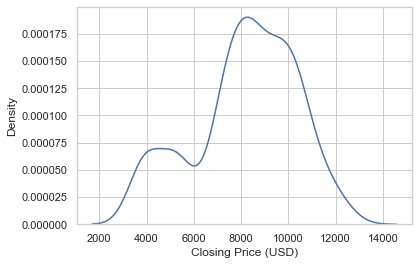

In [71]:
sns.set_theme(style="whitegrid")
ax = sns.kdeplot(BTC['Closing Price (USD)'])

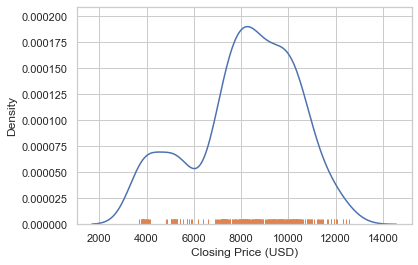

In [75]:
sns.set_theme(style="whitegrid")
ax = sns.kdeplot(BTC['Closing Price (USD)'])
ax = sns.rugplot(BTC['Closing Price (USD)'])#데이터 위치 표시

* sns.boxplot(): Draw a box plot to show distributions with respect to categories.
    
<br>

```
Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

In most cases, it is possible to use numpy or Python objects, but pandas
objects are preferable because the associated names will be used to
annotate the axes. Additionally, you can use Categorical types for the
grouping variables to control the order of plot elements.    

This function always treats one of the variables as categorical and
draws data at ordinal positions (0, 1, ... n) on the relevant axis, even
when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
x, y, hue : names of variables in ``data`` or vector data, optional
    Inputs for plotting long-form data. See examples for interpretation.        
data : DataFrame, array, or list of arrays, optional
    Dataset for plotting. If ``x`` and ``y`` are absent, this is
    interpreted as wide-form. Otherwise it is expected to be long-form.    
order, hue_order : lists of strings, optional
    Order to plot the categorical levels in, otherwise the levels are
    inferred from the data objects.        
orient : "v" | "h", optional
    Orientation of the plot (vertical or horizontal). This is usually
    inferred based on the type of the input variables, but it can be used
    to resolve ambiguitiy when both `x` and `y` are numeric or when
    plotting wide-form data.    
color : matplotlib color, optional
    Color for all of the elements, or seed for a gradient palette.    
palette : palette name, list, or dict
    Colors to use for the different levels of the ``hue`` variable. Should
    be something that can be interpreted by :func:`color_palette`, or a
    dictionary mapping hue levels to matplotlib colors.    
saturation : float, optional
    Proportion of the original saturation to draw colors at. Large patches
    often look better with slightly desaturated colors, but set this to
    ``1`` if you want the plot colors to perfectly match the input color
    spec.    
width : float, optional
    Width of a full element when not using hue nesting, or width of all the
    elements for one level of the major grouping variable.    
dodge : bool, optional
    When hue nesting is used, whether elements should be shifted along the
    categorical axis.    
fliersize : float, optional
    Size of the markers used to indicate outlier observations.
linewidth : float, optional
    Width of the gray lines that frame the plot elements.    
whis : float, optional
    Proportion of the IQR past the low and high quartiles to extend the
    plot whiskers. Points outside this range will be identified as
    outliers.
ax : matplotlib Axes, optional
    Axes object to draw the plot onto, otherwise uses the current Axes.    
kwargs : key, value mappings
    Other keyword arguments are passed through to
    :meth:`matplotlib.axes.Axes.boxplot`.

Returns
-------
ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it.    

See Also
--------
violinplot : A combination of boxplot and kernel density estimation.    
stripplot : A scatterplot where one variable is categorical. Can be used
            in conjunction with other plots to show each observation.    
swarmplot : A categorical scatterplot where the points do not overlap. Can
            be used with other plots to show each observation.    
catplot : Combine a categorical plot with a :class:`FacetGrid`.    

Examples
--------

Draw a single horizontal boxplot:

.. plot::
    :context: close-figs

    >>> import seaborn as sns
    >>> sns.set_theme(style="whitegrid")
    >>> tips = sns.load_dataset("tips")
    >>> ax = sns.boxplot(x=tips["total_bill"])

Draw a vertical boxplot grouped by a categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="day", y="total_bill", data=tips)

Draw a boxplot with nested grouping by two categorical variables:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="day", y="total_bill", hue="smoker",
    ...                  data=tips, palette="Set3")

Draw a boxplot with nested grouping when some bins are empty:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="day", y="total_bill", hue="time",
    ...                  data=tips, linewidth=2.5)

Control box order by passing an explicit order:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="time", y="tip", data=tips,
    ...                  order=["Dinner", "Lunch"])

Draw a boxplot for each numeric variable in a DataFrame:

.. plot::
    :context: close-figs

    >>> iris = sns.load_dataset("iris")
    >>> ax = sns.boxplot(data=iris, orient="h", palette="Set2")

Use ``hue`` without changing box position or width:

.. plot::
    :context: close-figs

    >>> tips["weekend"] = tips["day"].isin(["Sat", "Sun"])
    >>> ax = sns.boxplot(x="day", y="total_bill", hue="weekend",
    ...                  data=tips, dodge=False)

Use :func:`swarmplot` to show the datapoints on top of the boxes:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="day", y="total_bill", data=tips)
    >>> ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")

Use :func:`catplot` to combine a :func:`boxplot` and a
:class:`FacetGrid`. This allows grouping within additional categorical
variables. Using :func:`catplot` is safer than using :class:`FacetGrid`
directly, as it ensures synchronization of variable order across facets:

.. plot::
    :context: close-figs

    >>> g = sns.catplot(x="sex", y="total_bill",
    ...                 hue="smoker", col="time",
    ...                 data=tips, kind="box",
    ...                 height=4, aspect=.7);
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\categorical.py
Type:      function
```

<br>

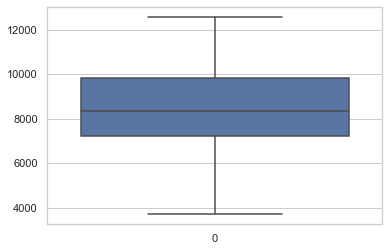

In [60]:
ax = sns.boxplot(data=BTC['Closing Price (USD)']#인정값(정상데이터)

* sns.violinplot(): Draw a combination of boxplot and kernel density estimate.

<br>

```
Signature:
sns.violinplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    bw='scott',
    cut=2,
    scale='area',
    scale_hue=True,
    gridsize=100,
    width=0.8,
    inner='box',
    split=False,
    dodge=True,
    orient=None,
    linewidth=None,
    color=None,
    palette=None,
    saturation=0.75,
    ax=None,
    **kwargs,
)
Docstring:
Draw a combination of boxplot and kernel density estimate.

A violin plot plays a similar role as a box and whisker plot. It shows the
distribution of quantitative data across several levels of one (or more)
categorical variables such that those distributions can be compared. Unlike
a box plot, in which all of the plot components correspond to actual
datapoints, the violin plot features a kernel density estimation of the
underlying distribution.

This can be an effective and attractive way to show multiple distributions
of data at once, but keep in mind that the estimation procedure is
influenced by the sample size, and violins for relatively small samples
might look misleadingly smooth.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

In most cases, it is possible to use numpy or Python objects, but pandas
objects are preferable because the associated names will be used to
annotate the axes. Additionally, you can use Categorical types for the
grouping variables to control the order of plot elements.    

This function always treats one of the variables as categorical and
draws data at ordinal positions (0, 1, ... n) on the relevant axis, even
when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
x, y, hue : names of variables in ``data`` or vector data, optional
    Inputs for plotting long-form data. See examples for interpretation.        
data : DataFrame, array, or list of arrays, optional
    Dataset for plotting. If ``x`` and ``y`` are absent, this is
    interpreted as wide-form. Otherwise it is expected to be long-form.    
order, hue_order : lists of strings, optional
    Order to plot the categorical levels in, otherwise the levels are
    inferred from the data objects.        
bw : {'scott', 'silverman', float}, optional
    Either the name of a reference rule or the scale factor to use when
    computing the kernel bandwidth. The actual kernel size will be
    determined by multiplying the scale factor by the standard deviation of
    the data within each bin.
cut : float, optional
    Distance, in units of bandwidth size, to extend the density past the
    extreme datapoints. Set to 0 to limit the violin range within the range
    of the observed data (i.e., to have the same effect as ``trim=True`` in
    ``ggplot``.
scale : {"area", "count", "width"}, optional
    The method used to scale the width of each violin. If ``area``, each
    violin will have the same area. If ``count``, the width of the violins
    will be scaled by the number of observations in that bin. If ``width``,
    each violin will have the same width.
scale_hue : bool, optional
    When nesting violins using a ``hue`` variable, this parameter
    determines whether the scaling is computed within each level of the
    major grouping variable (``scale_hue=True``) or across all the violins
    on the plot (``scale_hue=False``).
gridsize : int, optional
    Number of points in the discrete grid used to compute the kernel
    density estimate.
width : float, optional
    Width of a full element when not using hue nesting, or width of all the
    elements for one level of the major grouping variable.    
inner : {"box", "quartile", "point", "stick", None}, optional
    Representation of the datapoints in the violin interior. If ``box``,
    draw a miniature boxplot. If ``quartiles``, draw the quartiles of the
    distribution.  If ``point`` or ``stick``, show each underlying
    datapoint. Using ``None`` will draw unadorned violins.
split : bool, optional
    When using hue nesting with a variable that takes two levels, setting
    ``split`` to True will draw half of a violin for each level. This can
    make it easier to directly compare the distributions.
dodge : bool, optional
    When hue nesting is used, whether elements should be shifted along the
    categorical axis.    
orient : "v" | "h", optional
    Orientation of the plot (vertical or horizontal). This is usually
    inferred based on the type of the input variables, but it can be used
    to resolve ambiguitiy when both `x` and `y` are numeric or when
    plotting wide-form data.    
linewidth : float, optional
    Width of the gray lines that frame the plot elements.    
color : matplotlib color, optional
    Color for all of the elements, or seed for a gradient palette.    
palette : palette name, list, or dict
    Colors to use for the different levels of the ``hue`` variable. Should
    be something that can be interpreted by :func:`color_palette`, or a
    dictionary mapping hue levels to matplotlib colors.    
saturation : float, optional
    Proportion of the original saturation to draw colors at. Large patches
    often look better with slightly desaturated colors, but set this to
    ``1`` if you want the plot colors to perfectly match the input color
    spec.    
ax : matplotlib Axes, optional
    Axes object to draw the plot onto, otherwise uses the current Axes.    

Returns
-------
ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it.    

See Also
--------
boxplot : A traditional box-and-whisker plot with a similar API.    
stripplot : A scatterplot where one variable is categorical. Can be used
            in conjunction with other plots to show each observation.    
swarmplot : A categorical scatterplot where the points do not overlap. Can
            be used with other plots to show each observation.    
catplot : Combine a categorical plot with a :class:`FacetGrid`.    

Examples
--------

Draw a single horizontal violinplot:

.. plot::
    :context: close-figs

    >>> import seaborn as sns
    >>> sns.set_theme(style="whitegrid")
    >>> tips = sns.load_dataset("tips")
    >>> ax = sns.violinplot(x=tips["total_bill"])

Draw a vertical violinplot grouped by a categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", data=tips)

Draw a violinplot with nested grouping by two categorical variables:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
    ...                     data=tips, palette="muted")

Draw split violins to compare the across the hue variable:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
    ...                     data=tips, palette="muted", split=True)

Control violin order by passing an explicit order:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="time", y="tip", data=tips,
    ...                     order=["Dinner", "Lunch"])

Scale the violin width by the number of observations in each bin:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="sex",
    ...                     data=tips, palette="Set2", split=True,
    ...                     scale="count")

Draw the quartiles as horizontal lines instead of a mini-box:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="sex",
    ...                     data=tips, palette="Set2", split=True,
    ...                     scale="count", inner="quartile")

Show each observation with a stick inside the violin:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="sex",
    ...                     data=tips, palette="Set2", split=True,
    ...                     scale="count", inner="stick")

Scale the density relative to the counts across all bins:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="sex",
    ...                     data=tips, palette="Set2", split=True,
    ...                     scale="count", inner="stick", scale_hue=False)

Use a narrow bandwidth to reduce the amount of smoothing:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", hue="sex",
    ...                     data=tips, palette="Set2", split=True,
    ...                     scale="count", inner="stick",
    ...                     scale_hue=False, bw=.2)

Draw horizontal violins:

.. plot::
    :context: close-figs

    >>> planets = sns.load_dataset("planets")
    >>> ax = sns.violinplot(x="orbital_period", y="method",
    ...                     data=planets[planets.orbital_period < 1000],
    ...                     scale="width", palette="Set3")

Don't let density extend past extreme values in the data:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="orbital_period", y="method",
    ...                     data=planets[planets.orbital_period < 1000],
    ...                     cut=0, scale="width", palette="Set3")

Use ``hue`` without changing violin position or width:

.. plot::
    :context: close-figs

    >>> tips["weekend"] = tips["day"].isin(["Sat", "Sun"])
    >>> ax = sns.violinplot(x="day", y="total_bill", hue="weekend",
    ...                     data=tips, dodge=False)

Use :func:`catplot` to combine a :func:`violinplot` and a
:class:`FacetGrid`. This allows grouping within additional categorical
variables. Using :func:`catplot` is safer than using :class:`FacetGrid`
directly, as it ensures synchronization of variable order across facets:

.. plot::
    :context: close-figs

    >>> g = sns.catplot(x="sex", y="total_bill",
    ...                 hue="smoker", col="time",
    ...                 data=tips, kind="violin", split=True,
    ...                 height=4, aspect=.7);
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\categorical.py
Type:      function
```

<br>

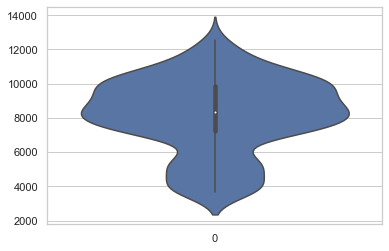

In [83]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=BTC['Closing Price (USD)'])#상자 수염 그래프+커널밀도

* sns.swarmplot(): Draw a categorical scatterplot with non-overlapping points.

<br>

```
Signature:
sns.swarmplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    dodge=False,
    orient=None,
    color=None,
    palette=None,
    size=5,
    edgecolor='gray',
    linewidth=0,
    ax=None,
    **kwargs,
)
Docstring:
Draw a categorical scatterplot with non-overlapping points.

This function is similar to :func:`stripplot`, but the points are adjusted
(only along the categorical axis) so that they don't overlap. This gives a
better representation of the distribution of values, but it does not scale
well to large numbers of observations. This style of plot is sometimes
called a "beeswarm".

A swarm plot can be drawn on its own, but it is also a good complement
to a box or violin plot in cases where you want to show all observations
along with some representation of the underlying distribution.

Arranging the points properly requires an accurate transformation between
data and point coordinates. This means that non-default axis limits must
be set *before* drawing the plot.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

In most cases, it is possible to use numpy or Python objects, but pandas
objects are preferable because the associated names will be used to
annotate the axes. Additionally, you can use Categorical types for the
grouping variables to control the order of plot elements.    

This function always treats one of the variables as categorical and
draws data at ordinal positions (0, 1, ... n) on the relevant axis, even
when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
x, y, hue : names of variables in ``data`` or vector data, optional
    Inputs for plotting long-form data. See examples for interpretation.        
data : DataFrame, array, or list of arrays, optional
    Dataset for plotting. If ``x`` and ``y`` are absent, this is
    interpreted as wide-form. Otherwise it is expected to be long-form.    
order, hue_order : lists of strings, optional
    Order to plot the categorical levels in, otherwise the levels are
    inferred from the data objects.        
dodge : bool, optional
    When using ``hue`` nesting, setting this to ``True`` will separate
    the strips for different hue levels along the categorical axis.
    Otherwise, the points for each level will be plotted in one swarm.
orient : "v" | "h", optional
    Orientation of the plot (vertical or horizontal). This is usually
    inferred based on the type of the input variables, but it can be used
    to resolve ambiguitiy when both `x` and `y` are numeric or when
    plotting wide-form data.    
color : matplotlib color, optional
    Color for all of the elements, or seed for a gradient palette.    
palette : palette name, list, or dict
    Colors to use for the different levels of the ``hue`` variable. Should
    be something that can be interpreted by :func:`color_palette`, or a
    dictionary mapping hue levels to matplotlib colors.    
size : float, optional
    Radius of the markers, in points.
edgecolor : matplotlib color, "gray" is special-cased, optional
    Color of the lines around each point. If you pass ``"gray"``, the
    brightness is determined by the color palette used for the body
    of the points.
linewidth : float, optional
    Width of the gray lines that frame the plot elements.    
ax : matplotlib Axes, optional
    Axes object to draw the plot onto, otherwise uses the current Axes.    
kwargs : key, value mappings
    Other keyword arguments are passed through to
    :meth:`matplotlib.axes.Axes.scatter`.

Returns
-------
ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it.    

See Also
--------
boxplot : A traditional box-and-whisker plot with a similar API.    
violinplot : A combination of boxplot and kernel density estimation.    
stripplot : A scatterplot where one variable is categorical. Can be used
            in conjunction with other plots to show each observation.    
catplot : Combine a categorical plot with a :class:`FacetGrid`.    

Examples
--------

Draw a single horizontal swarm plot:

.. plot::
    :context: close-figs

    >>> import seaborn as sns
    >>> sns.set_theme(style="whitegrid")
    >>> tips = sns.load_dataset("tips")
    >>> ax = sns.swarmplot(x=tips["total_bill"])

Group the swarms by a categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="day", y="total_bill", data=tips)

Draw horizontal swarms:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="total_bill", y="day", data=tips)

Color the points using a second categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="day", y="total_bill", hue="sex", data=tips)

Split each level of the ``hue`` variable along the categorical axis:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",
    ...                    data=tips, palette="Set2", dodge=True)

Control swarm order by passing an explicit order:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="time", y="total_bill", data=tips,
    ...                    order=["Dinner", "Lunch"])

Plot using larger points:

.. plot::
    :context: close-figs

    >>> ax = sns.swarmplot(x="time", y="total_bill", data=tips, size=6)

Draw swarms of observations on top of a box plot:

.. plot::
    :context: close-figs

    >>> ax = sns.boxplot(x="total_bill", y="day", data=tips, whis=np.inf)
    >>> ax = sns.swarmplot(x="total_bill", y="day", data=tips, color=".2")

Draw swarms of observations on top of a violin plot:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", data=tips, inner=None)
    >>> ax = sns.swarmplot(x="day", y="total_bill", data=tips,
    ...                    color="white", edgecolor="gray")

Use :func:`catplot` to combine a :func:`swarmplot` and a
:class:`FacetGrid`. This allows grouping within additional categorical
variables. Using :func:`catplot` is safer than using :class:`FacetGrid`
directly, as it ensures synchronization of variable order across facets:

.. plot::
    :context: close-figs

    >>> g = sns.catplot(x="sex", y="total_bill",
    ...                 hue="smoker", col="time",
    ...                 data=tips, kind="swarm",
    ...                 height=4, aspect=.7);
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\categorical.py
Type:      function
```

<br>

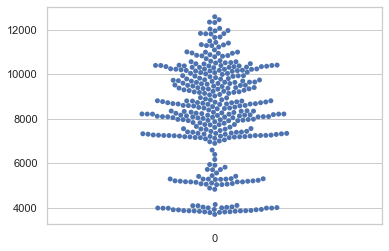

In [61]:
ax = sns.swarmplot(data=BTC['Closing Price (USD)'])

* sns.stripplot(): Draw a scatterplot where one variable is categorical.

<br>

```
Signature:
sns.stripplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    jitter=True,
    dodge=False,
    orient=None,
    color=None,
    palette=None,
    size=5,
    edgecolor='gray',
    linewidth=0,
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatterplot where one variable is categorical.

A strip plot can be drawn on its own, but it is also a good complement
to a box or violin plot in cases where you want to show all observations
along with some representation of the underlying distribution.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

In most cases, it is possible to use numpy or Python objects, but pandas
objects are preferable because the associated names will be used to
annotate the axes. Additionally, you can use Categorical types for the
grouping variables to control the order of plot elements.    

This function always treats one of the variables as categorical and
draws data at ordinal positions (0, 1, ... n) on the relevant axis, even
when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
x, y, hue : names of variables in ``data`` or vector data, optional
    Inputs for plotting long-form data. See examples for interpretation.        
data : DataFrame, array, or list of arrays, optional
    Dataset for plotting. If ``x`` and ``y`` are absent, this is
    interpreted as wide-form. Otherwise it is expected to be long-form.    
order, hue_order : lists of strings, optional
    Order to plot the categorical levels in, otherwise the levels are
    inferred from the data objects.        
jitter : float, ``True``/``1`` is special-cased, optional
    Amount of jitter (only along the categorical axis) to apply. This
    can be useful when you have many points and they overlap, so that
    it is easier to see the distribution. You can specify the amount
    of jitter (half the width of the uniform random variable support),
    or just use ``True`` for a good default.
dodge : bool, optional
    When using ``hue`` nesting, setting this to ``True`` will separate
    the strips for different hue levels along the categorical axis.
    Otherwise, the points for each level will be plotted on top of
    each other.
orient : "v" | "h", optional
    Orientation of the plot (vertical or horizontal). This is usually
    inferred based on the type of the input variables, but it can be used
    to resolve ambiguitiy when both `x` and `y` are numeric or when
    plotting wide-form data.    
color : matplotlib color, optional
    Color for all of the elements, or seed for a gradient palette.    
palette : palette name, list, or dict
    Colors to use for the different levels of the ``hue`` variable. Should
    be something that can be interpreted by :func:`color_palette`, or a
    dictionary mapping hue levels to matplotlib colors.    
size : float, optional
    Radius of the markers, in points.
edgecolor : matplotlib color, "gray" is special-cased, optional
    Color of the lines around each point. If you pass ``"gray"``, the
    brightness is determined by the color palette used for the body
    of the points.
linewidth : float, optional
    Width of the gray lines that frame the plot elements.    
ax : matplotlib Axes, optional
    Axes object to draw the plot onto, otherwise uses the current Axes.    
kwargs : key, value mappings
    Other keyword arguments are passed through to
    :meth:`matplotlib.axes.Axes.scatter`.

Returns
-------
ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it.    

See Also
--------
swarmplot : A categorical scatterplot where the points do not overlap. Can
            be used with other plots to show each observation.    
boxplot : A traditional box-and-whisker plot with a similar API.    
violinplot : A combination of boxplot and kernel density estimation.    
catplot : Combine a categorical plot with a :class:`FacetGrid`.    

Examples
--------

Draw a single horizontal strip plot:

.. plot::
    :context: close-figs

    >>> import seaborn as sns
    >>> sns.set_theme(style="whitegrid")
    >>> tips = sns.load_dataset("tips")
    >>> ax = sns.stripplot(x=tips["total_bill"])

Group the strips by a categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="day", y="total_bill", data=tips)

Use a smaller amount of jitter:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="day", y="total_bill", data=tips, jitter=0.05)

Draw horizontal strips:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="total_bill", y="day", data=tips)

Draw outlines around the points:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="total_bill", y="day", data=tips,
    ...                    linewidth=1)

Nest the strips within a second categorical variable:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="sex", y="total_bill", hue="day", data=tips)

Draw each level of the ``hue`` variable at different locations on the
major categorical axis:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="day", y="total_bill", hue="smoker",
    ...                    data=tips, palette="Set2", dodge=True)

Control strip order by passing an explicit order:

.. plot::
    :context: close-figs

    >>> ax = sns.stripplot(x="time", y="tip", data=tips,
    ...                    order=["Dinner", "Lunch"])

Draw strips with large points and different aesthetics:

.. plot::
    :context: close-figs

    >>> ax =  sns.stripplot(x="day", y="total_bill", hue="smoker",
    ...                    data=tips, palette="Set2", size=20, marker="D",
    ...                    edgecolor="gray", alpha=.25)

Draw strips of observations on top of a box plot:

.. plot::
    :context: close-figs

    >>> import numpy as np
    >>> ax = sns.boxplot(x="tip", y="day", data=tips, whis=np.inf)
    >>> ax = sns.stripplot(x="tip", y="day", data=tips, color=".3")

Draw strips of observations on top of a violin plot:

.. plot::
    :context: close-figs

    >>> ax = sns.violinplot(x="day", y="total_bill", data=tips,
    ...                     inner=None, color=".8")
    >>> ax = sns.stripplot(x="day", y="total_bill", data=tips)

Use :func:`catplot` to combine a :func:`stripplot` and a
:class:`FacetGrid`. This allows grouping within additional categorical
variables. Using :func:`catplot` is safer than using :class:`FacetGrid`
directly, as it ensures synchronization of variable order across facets:

.. plot::
    :context: close-figs

    >>> g = sns.catplot(x="sex", y="total_bill",
    ...                 hue="smoker", col="time",
    ...                 data=tips, kind="strip",
    ...                 height=4, aspect=.7);
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\categorical.py
Type:      function
```

<br>

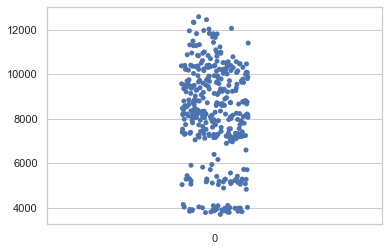

In [62]:
ax = sns.stripplot(data=BTC['Closing Price (USD)'])

* np.mean(): Compute the arithmetic mean along the specified axis.

<br>

```
Signature: np.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)
Docstring:
Compute the arithmetic mean along the specified axis.

Returns the average of the array elements.  The average is taken over
the flattened array by default, otherwise over the specified axis.
`float64` intermediate and return values are used for integer inputs.

Parameters
----------
a : array_like
    Array containing numbers whose mean is desired. If `a` is not an
    array, a conversion is attempted.
axis : None or int or tuple of ints, optional
    Axis or axes along which the means are computed. The default is to
    compute the mean of the flattened array.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a mean is performed over multiple axes,
    instead of a single axis or all the axes as before.
dtype : data-type, optional
    Type to use in computing the mean.  For integer inputs, the default
    is `float64`; for floating point inputs, it is the same as the
    input dtype.
out : ndarray, optional
    Alternate output array in which to place the result.  The default
    is ``None``; if provided, it must have the same shape as the
    expected output, but the type will be cast if necessary.
    See `ufuncs-output-type` for more details.

keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the input array.

    If the default value is passed, then `keepdims` will not be
    passed through to the `mean` method of sub-classes of
    `ndarray`, however any non-default value will be.  If the
    sub-class' method does not implement `keepdims` any
    exceptions will be raised.

Returns
-------
m : ndarray, see dtype parameter above
    If `out=None`, returns a new array containing the mean values,
    otherwise a reference to the output array is returned.

See Also
--------
average : Weighted average
std, var, nanmean, nanstd, nanvar

Notes
-----
The arithmetic mean is the sum of the elements along the axis divided
by the number of elements.

Note that for floating-point input, the mean is computed using the
same precision the input has.  Depending on the input data, this can
cause the results to be inaccurate, especially for `float32` (see
example below).  Specifying a higher-precision accumulator using the
`dtype` keyword can alleviate this issue.

By default, `float16` results are computed using `float32` intermediates
for extra precision.

Examples
--------
>>> a = np.array([[1, 2], [3, 4]])
>>> np.mean(a)
2.5
>>> np.mean(a, axis=0)
array([2., 3.])
>>> np.mean(a, axis=1)
array([1.5, 3.5])

In single precision, `mean` can be inaccurate:

>>> a = np.zeros((2, 512*512), dtype=np.float32)
>>> a[0, :] = 1.0
>>> a[1, :] = 0.1
>>> np.mean(a)
0.54999924

Computing the mean in float64 is more accurate:

>>> np.mean(a, dtype=np.float64)
0.55000000074505806 # may vary
File:      c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py
Type:      function
```

<br>

In [27]:
BTC['Closing Price (USD)'].mean()

8198.42893655947

In [115]:
BTC['Closing Price (USD)'].sort_values()

5       3689.862893
0       3772.936335
4       3782.664101
1       3799.678543
3       3804.419170
           ...     
133    12054.183793
121    12316.953012
131    12335.999395
119    12444.925860
132    12575.904067
Name: Closing Price (USD), Length: 365, dtype: float64

In [106]:
# 절사평균(Trimmed Mean)

from scipy import stats

stats.trim_mean(BTC['Closing Price (USD)'], 0.1)

8321.009952082226

In [116]:
# 원저화평균(Winsorized Mean)

from scipy.stats.mstats import winsorize

sorted_closing = BTC['Closing Price (USD)'].sort_values()

# The 10% of the lowest value and the 20% of the highest values are replaced.
winsorize(sorted_closing, limits=[0.1, 0.2])

masked_array(data=[ 5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5028.32108194,  5028.32108194,
                    5028.32108194,  5030.93327059,  5045.67516591,
                    5049.60582354,  5066.86704016,  5077.51586409,
                    5102.15075264,  5132.22752627,  5151.43349

* np.median(): Compute the median along the specified axis.

<br>

```
Signature: np.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)
Docstring:
Compute the median along the specified axis.

Returns the median of the array elements.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
axis : {int, sequence of int, None}, optional
    Axis or axes along which the medians are computed. The default
    is to compute the median along a flattened version of the array.
    A sequence of axes is supported since version 1.9.0.
out : ndarray, optional
    Alternative output array in which to place the result. It must
    have the same shape and buffer length as the expected output,
    but the type (of the output) will be cast if necessary.
overwrite_input : bool, optional
   If True, then allow use of memory of input array `a` for
   calculations. The input array will be modified by the call to
   `median`. This will save memory when you do not need to preserve
   the contents of the input array. Treat the input as undefined,
   but it will probably be fully or partially sorted. Default is
   False. If `overwrite_input` is ``True`` and `a` is not already an
   `ndarray`, an error will be raised.
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the original `arr`.

    .. versionadded:: 1.9.0

Returns
-------
median : ndarray
    A new array holding the result. If the input contains integers
    or floats smaller than ``float64``, then the output data-type is
    ``np.float64``.  Otherwise, the data-type of the output is the
    same as that of the input. If `out` is specified, that array is
    returned instead.

See Also
--------
mean, percentile

Notes
-----
Given a vector ``V`` of length ``N``, the median of ``V`` is the
middle value of a sorted copy of ``V``, ``V_sorted`` - i
e., ``V_sorted[(N-1)/2]``, when ``N`` is odd, and the average of the
two middle values of ``V_sorted`` when ``N`` is even.

Examples
--------
>>> a = np.array([[10, 7, 4], [3, 2, 1]])
>>> a
array([[10,  7,  4],
       [ 3,  2,  1]])
>>> np.median(a)
3.5
>>> np.median(a, axis=0)
array([6.5, 4.5, 2.5])
>>> np.median(a, axis=1)
array([7.,  2.])
>>> m = np.median(a, axis=0)
>>> out = np.zeros_like(m)
>>> np.median(a, axis=0, out=m)
array([6.5,  4.5,  2.5])
>>> m
array([6.5,  4.5,  2.5])
>>> b = a.copy()
>>> np.median(b, axis=1, overwrite_input=True)
array([7.,  2.])
>>> assert not np.all(a==b)
>>> b = a.copy()
>>> np.median(b, axis=None, overwrite_input=True)
3.5
>>> assert not np.all(a==b)
File:      c:\programdata\anaconda3\lib\site-packages\numpy\lib\function_base.py
Type:      function
```

<br>

In [28]:
BTC['Closing Price (USD)'].median()

8347.567505406

* np.quantile(): Compute the q-th quantile of the data along the specified axis.

<br>

```
Signature:
np.quantile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    interpolation='linear',
    keepdims=False,
)
Docstring:
Compute the q-th quantile of the data along the specified axis.

.. versionadded:: 1.15.0

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Quantile or sequence of quantiles to compute, which must be between
    0 and 1 inclusive.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the quantiles are computed. The
    default is to compute the quantile(s) along a flattened
    version of the array.
out : ndarray, optional
    Alternative output array in which to place the result. It must
    have the same shape and buffer length as the expected output,
    but the type (of the output) will be cast if necessary.
overwrite_input : bool, optional
    If True, then allow the input array `a` to be modified by intermediate
    calculations, to save memory. In this case, the contents of the input
    `a` after this function completes is undefined.
interpolation : {'linear', 'lower', 'higher', 'midpoint', 'nearest'}
    This optional parameter specifies the interpolation method to
    use when the desired quantile lies between two data points
    ``i < j``:

        * linear: ``i + (j - i) * fraction``, where ``fraction``
          is the fractional part of the index surrounded by ``i``
          and ``j``.
        * lower: ``i``.
        * higher: ``j``.
        * nearest: ``i`` or ``j``, whichever is nearest.
        * midpoint: ``(i + j) / 2``.
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left in
    the result as dimensions with size one. With this option, the
    result will broadcast correctly against the original array `a`.

Returns
-------
quantile : scalar or ndarray
    If `q` is a single quantile and `axis=None`, then the result
    is a scalar. If multiple quantiles are given, first axis of
    the result corresponds to the quantiles. The other axes are
    the axes that remain after the reduction of `a`. If the input
    contains integers or floats smaller than ``float64``, the output
    data-type is ``float64``. Otherwise, the output data-type is the
    same as that of the input. If `out` is specified, that array is
    returned instead.

See Also
--------
mean
percentile : equivalent to quantile, but with q in the range [0, 100].
median : equivalent to ``quantile(..., 0.5)``
nanquantile

Notes
-----
Given a vector ``V`` of length ``N``, the q-th quantile of
``V`` is the value ``q`` of the way from the minimum to the
maximum in a sorted copy of ``V``. The values and distances of
the two nearest neighbors as well as the `interpolation` parameter
will determine the quantile if the normalized ranking does not
match the location of ``q`` exactly. This function is the same as
the median if ``q=0.5``, the same as the minimum if ``q=0.0`` and the
same as the maximum if ``q=1.0``.

Examples
--------
>>> a = np.array([[10, 7, 4], [3, 2, 1]])
>>> a
array([[10,  7,  4],
       [ 3,  2,  1]])
>>> np.quantile(a, 0.5)
3.5
>>> np.quantile(a, 0.5, axis=0)
array([6.5, 4.5, 2.5])
>>> np.quantile(a, 0.5, axis=1)
array([7.,  2.])
>>> np.quantile(a, 0.5, axis=1, keepdims=True)
array([[7.],
       [2.]])
>>> m = np.quantile(a, 0.5, axis=0)
>>> out = np.zeros_like(m)
>>> np.quantile(a, 0.5, axis=0, out=out)
array([6.5, 4.5, 2.5])
>>> m
array([6.5, 4.5, 2.5])
>>> b = a.copy()
>>> np.quantile(b, 0.5, axis=1, overwrite_input=True)
array([7.,  2.])
>>> assert not np.all(a == b)
File:      c:\programdata\anaconda3\lib\site-packages\numpy\lib\function_base.py
Type:      function
```

<br>

In [45]:
q2 = BTC['Closing Price (USD)'].quantile(0.5) #분위수
q2

8347.567505406

* np.var(): Compute the variance along the specified axis.

<br>
    
```
Signature: np.var(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)
Docstring:
Compute the variance along the specified axis.

Returns the variance of the array elements, a measure of the spread of a
distribution.  The variance is computed for the flattened array by
default, otherwise over the specified axis.

Parameters
----------
a : array_like
    Array containing numbers whose variance is desired.  If `a` is not an
    array, a conversion is attempted.
axis : None or int or tuple of ints, optional
    Axis or axes along which the variance is computed.  The default is to
    compute the variance of the flattened array.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a variance is performed over multiple axes,
    instead of a single axis or all the axes as before.
dtype : data-type, optional
    Type to use in computing the variance.  For arrays of integer type
    the default is `float64`; for arrays of float types it is the same as
    the array type.
out : ndarray, optional
    Alternate output array in which to place the result.  It must have
    the same shape as the expected output, but the type is cast if
    necessary.
ddof : int, optional
    "Delta Degrees of Freedom": the divisor used in the calculation is
    ``N - ddof``, where ``N`` represents the number of elements. By
    default `ddof` is zero.
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the input array.

    If the default value is passed, then `keepdims` will not be
    passed through to the `var` method of sub-classes of
    `ndarray`, however any non-default value will be.  If the
    sub-class' method does not implement `keepdims` any
    exceptions will be raised.

Returns
-------
variance : ndarray, see dtype parameter above
    If ``out=None``, returns a new array containing the variance;
    otherwise, a reference to the output array is returned.

See Also
--------
std, mean, nanmean, nanstd, nanvar
ufuncs-output-type

Notes
-----
The variance is the average of the squared deviations from the mean,
i.e.,  ``var = mean(abs(x - x.mean())**2)``.

The mean is normally calculated as ``x.sum() / N``, where ``N = len(x)``.
If, however, `ddof` is specified, the divisor ``N - ddof`` is used
instead.  In standard statistical practice, ``ddof=1`` provides an
unbiased estimator of the variance of a hypothetical infinite population.
``ddof=0`` provides a maximum likelihood estimate of the variance for
normally distributed variables.

Note that for complex numbers, the absolute value is taken before
squaring, so that the result is always real and nonnegative.

For floating-point input, the variance is computed using the same
precision the input has.  Depending on the input data, this can cause
the results to be inaccurate, especially for `float32` (see example
below).  Specifying a higher-accuracy accumulator using the ``dtype``
keyword can alleviate this issue.

Examples
--------
>>> a = np.array([[1, 2], [3, 4]])
>>> np.var(a)
1.25
>>> np.var(a, axis=0)
array([1.,  1.])
>>> np.var(a, axis=1)
array([0.25,  0.25])

In single precision, var() can be inaccurate:

>>> a = np.zeros((2, 512*512), dtype=np.float32)
>>> a[0, :] = 1.0
>>> a[1, :] = 0.1
>>> np.var(a)
0.20250003

Computing the variance in float64 is more accurate:

>>> np.var(a, dtype=np.float64)
0.20249999932944759 # may vary
>>> ((1-0.55)**2 + (0.1-0.55)**2)/2
0.2025
File:      c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py
Type:      function
```

<br>

In [29]:
BTC['Closing Price (USD)'].var()

4699747.35205975

In [32]:
BTC['Closing Price (USD)'].var(ddof=1)

4699747.35205975

In [31]:
BTC['Closing Price (USD)'].var(ddof=0)

4686871.331917121

* np.std(): Compute the standard deviation along the specified axis.

<br>

```
Signature: np.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)
Docstring:
Compute the standard deviation along the specified axis.

Returns the standard deviation, a measure of the spread of a distribution,
of the array elements. The standard deviation is computed for the
flattened array by default, otherwise over the specified axis.

Parameters
----------
a : array_like
    Calculate the standard deviation of these values.
axis : None or int or tuple of ints, optional
    Axis or axes along which the standard deviation is computed. The
    default is to compute the standard deviation of the flattened array.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a standard deviation is performed over
    multiple axes, instead of a single axis or all the axes as before.
dtype : dtype, optional
    Type to use in computing the standard deviation. For arrays of
    integer type the default is float64, for arrays of float types it is
    the same as the array type.
out : ndarray, optional
    Alternative output array in which to place the result. It must have
    the same shape as the expected output but the type (of the calculated
    values) will be cast if necessary.
ddof : int, optional
    Means Delta Degrees of Freedom.  The divisor used in calculations
    is ``N - ddof``, where ``N`` represents the number of elements.
    By default `ddof` is zero.
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the input array.

    If the default value is passed, then `keepdims` will not be
    passed through to the `std` method of sub-classes of
    `ndarray`, however any non-default value will be.  If the
    sub-class' method does not implement `keepdims` any
    exceptions will be raised.

Returns
-------
standard_deviation : ndarray, see dtype parameter above.
    If `out` is None, return a new array containing the standard deviation,
    otherwise return a reference to the output array.

See Also
--------
var, mean, nanmean, nanstd, nanvar
ufuncs-output-type

Notes
-----
The standard deviation is the square root of the average of the squared
deviations from the mean, i.e., ``std = sqrt(mean(abs(x - x.mean())**2))``.

The average squared deviation is normally calculated as
``x.sum() / N``, where ``N = len(x)``.  If, however, `ddof` is specified,
the divisor ``N - ddof`` is used instead. In standard statistical
practice, ``ddof=1`` provides an unbiased estimator of the variance
of the infinite population. ``ddof=0`` provides a maximum likelihood
estimate of the variance for normally distributed variables. The
standard deviation computed in this function is the square root of
the estimated variance, so even with ``ddof=1``, it will not be an
unbiased estimate of the standard deviation per se.

Note that, for complex numbers, `std` takes the absolute
value before squaring, so that the result is always real and nonnegative.

For floating-point input, the *std* is computed using the same
precision the input has. Depending on the input data, this can cause
the results to be inaccurate, especially for float32 (see example below).
Specifying a higher-accuracy accumulator using the `dtype` keyword can
alleviate this issue.

Examples
--------
>>> a = np.array([[1, 2], [3, 4]])
>>> np.std(a)
1.1180339887498949 # may vary
>>> np.std(a, axis=0)
array([1.,  1.])
>>> np.std(a, axis=1)
array([0.5,  0.5])

In single precision, std() can be inaccurate:

>>> a = np.zeros((2, 512*512), dtype=np.float32)
>>> a[0, :] = 1.0
>>> a[1, :] = 0.1
>>> np.std(a)
0.45000005

Computing the standard deviation in float64 is more accurate:

>>> np.std(a, dtype=np.float64)
0.44999999925494177 # may vary
File:      c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py
Type:      function
```

<br>

In [34]:
BTC['Closing Price (USD)'].std()

2167.8900691824183

In [35]:
BTC['Closing Price (USD)'].std(ddof=1)

2167.8900691824183

In [36]:
BTC['Closing Price (USD)'].std(ddof=0)

2164.918319918126

In [44]:
# IQR(Inter-Quantle Range) 사분위수[사분위수간] 범위

from scipy.stats import iqr

iqr(BTC['Closing Price (USD)'])

2625.1662545570007

In [47]:
# 제 1사분위수
q1 = BTC['Closing Price (USD)'].quantile(0.25)
# 제 3사분위수
q3 = BTC['Closing Price (USD)'].quantile(0.75)
# IQR(Inter-Quantle Range) 사분위수[사분위수간] 범위
iqr = q3 - q1
iqr

2625.1662545570007

In [99]:
# MAD(Mean Absolute Deviation): median(|x_i -median(x)|)
import numpy as np

def get_median_absolute_deviation(data):
    return np.median(np.absolute(data - np.median(data, axis=0)), axis=0)

In [100]:
get_median_absolute_deviation(BTC['Closing Price (USD)'])

1289.0565894094998

In [102]:
from statsmodels import robust

robust.mad(BTC['Closing Price (USD)'], c=1)

1289.0565894094998

In [104]:
# Absolute Mean Deviation

from numpy import mean, absolute
  
# Absolute mean deviation
mean(absolute(BTC['Closing Price (USD)'] - mean(BTC['Closing Price (USD)'])))

1722.1596121874745

* BTC.cov(): Compute pairwise covariance of columns, excluding NA/null values.

<br>

```
Signature: BTC.cov(min_periods: 'Optional[int]' = None, ddof: 'Optional[int]' = 1) -> 'DataFrame'
Docstring:
Compute pairwise covariance of columns, excluding NA/null values.

Compute the pairwise covariance among the series of a DataFrame.
The returned data frame is the `covariance matrix
<https://en.wikipedia.org/wiki/Covariance_matrix>`__ of the columns
of the DataFrame.

Both NA and null values are automatically excluded from the
calculation. (See the note below about bias from missing values.)
A threshold can be set for the minimum number of
observations for each value created. Comparisons with observations
below this threshold will be returned as ``NaN``.

This method is generally used for the analysis of time series data to
understand the relationship between different measures
across time.

Parameters
----------
min_periods : int, optional
    Minimum number of observations required per pair of columns
    to have a valid result.

ddof : int, default 1
    Delta degrees of freedom.  The divisor used in calculations
    is ``N - ddof``, where ``N`` represents the number of elements.

    .. versionadded:: 1.1.0

Returns
-------
DataFrame
    The covariance matrix of the series of the DataFrame.

See Also
--------
Series.cov : Compute covariance with another Series.
core.window.ExponentialMovingWindow.cov: Exponential weighted sample covariance.
core.window.Expanding.cov : Expanding sample covariance.
core.window.Rolling.cov : Rolling sample covariance.

Notes
-----
Returns the covariance matrix of the DataFrame's time series.
The covariance is normalized by N-ddof.

For DataFrames that have Series that are missing data (assuming that
data is `missing at random
<https://en.wikipedia.org/wiki/Missing_data#Missing_at_random>`__)
the returned covariance matrix will be an unbiased estimate
of the variance and covariance between the member Series.

However, for many applications this estimate may not be acceptable
because the estimate covariance matrix is not guaranteed to be positive
semi-definite. This could lead to estimate correlations having
absolute values which are greater than one, and/or a non-invertible
covariance matrix. See `Estimation of covariance matrices
<https://en.wikipedia.org/w/index.php?title=Estimation_of_covariance_
matrices>`__ for more details.

Examples
--------
>>> df = pd.DataFrame([(1, 2), (0, 3), (2, 0), (1, 1)],
...                   columns=['dogs', 'cats'])
>>> df.cov()
          dogs      cats
dogs  0.666667 -1.000000
cats -1.000000  1.666667

>>> np.random.seed(42)
>>> df = pd.DataFrame(np.random.randn(1000, 5),
...                   columns=['a', 'b', 'c', 'd', 'e'])
>>> df.cov()
          a         b         c         d         e
a  0.998438 -0.020161  0.059277 -0.008943  0.014144
b -0.020161  1.059352 -0.008543 -0.024738  0.009826
c  0.059277 -0.008543  1.010670 -0.001486 -0.000271
d -0.008943 -0.024738 -0.001486  0.921297 -0.013692
e  0.014144  0.009826 -0.000271 -0.013692  0.977795

**Minimum number of periods**

This method also supports an optional ``min_periods`` keyword
that specifies the required minimum number of non-NA observations for
each column pair in order to have a valid result:

>>> np.random.seed(42)
>>> df = pd.DataFrame(np.random.randn(20, 3),
...                   columns=['a', 'b', 'c'])
>>> df.loc[df.index[:5], 'a'] = np.nan
>>> df.loc[df.index[5:10], 'b'] = np.nan
>>> df.cov(min_periods=12)
          a         b         c
a  0.316741       NaN -0.150812
b       NaN  1.248003  0.191417
c -0.150812  0.191417  0.895202
File:      c:\programdata\anaconda3\lib\site-packages\pandas\core\frame.py
Type:      method
```

<br>

In [145]:
# 분산-공분산 행렬(Variance-Covariance Matrix)

BTC.cov()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Closing Price (USD),4.699747e+06,4.676888e+06,4.878453e+06,4.477845e+06
24h Open (USD),4.676888e+06,4.754474e+06,4.901207e+06,4.497651e+06
24h High (USD),4.878453e+06,4.901207e+06,5.118744e+06,4.651236e+06
24h Low (USD),4.477845e+06,4.497651e+06,4.651236e+06,4.309416e+06


* DataFrame.corr(): Compute pairwise correlation of columns, excluding NA/null values.

<br>

```
Signature: DataFrame.corr(method='pearson', min_periods=1) -> 'DataFrame'
Docstring:
Compute pairwise correlation of columns, excluding NA/null values.

Parameters
----------
method : {'pearson', 'kendall', 'spearman'} or callable
    Method of correlation:

    * pearson : standard correlation coefficient
    * kendall : Kendall Tau correlation coefficient
    * spearman : Spearman rank correlation
    * callable: callable with input two 1d ndarrays
        and returning a float. Note that the returned matrix from corr
        will have 1 along the diagonals and will be symmetric
        regardless of the callable's behavior.

        .. versionadded:: 0.24.0

min_periods : int, optional
    Minimum number of observations required per pair of columns
    to have a valid result. Currently only available for Pearson
    and Spearman correlation.

Returns
-------
DataFrame
    Correlation matrix.

See Also
--------
DataFrame.corrwith : Compute pairwise correlation with another
    DataFrame or Series.
Series.corr : Compute the correlation between two Series.

Examples
--------
>>> def histogram_intersection(a, b):
...     v = np.minimum(a, b).sum().round(decimals=1)
...     return v
>>> df = pd.DataFrame([(.2, .3), (.0, .6), (.6, .0), (.2, .1)],
...                   columns=['dogs', 'cats'])
>>> df.corr(method=histogram_intersection)
      dogs  cats
dogs   1.0   0.3
cats   0.3   1.0
File:      c:\programdata\anaconda3\lib\site-packages\pandas\core\frame.py
Type:      method
```

<br>

In [118]:
# 상관계수행렬(Correlation Coefficient Matrix)

BTC.corr()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Closing Price (USD),1.000000,0.989392,0.994634,0.994999
24h Open (USD),0.989392,1.000000,0.993505,0.993631
24h High (USD),0.994634,0.993505,1.000000,0.990325
24h Low (USD),0.994999,0.993631,0.990325,1.000000


* sns.heatmap(): 

<br>

```
Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise they are inferred from the
    data and other keyword arguments.
cmap : matplotlib colormap name or object, or list of colors, optional
    The mapping from data values to color space. If not provided, the
    default will depend on whether ``center`` is set.
center : float, optional
    The value at which to center the colormap when plotting divergant data.
    Using this parameter will change the default ``cmap`` if none is
    specified.
robust : bool, optional
    If True and ``vmin`` or ``vmax`` are absent, the colormap range is
    computed with robust quantiles instead of the extreme values.
annot : bool or rectangular dataset, optional
    If True, write the data value in each cell. If an array-like with the
    same shape as ``data``, then use this to annotate the heatmap instead
    of the data. Note that DataFrames will match on position, not index.
fmt : str, optional
    String formatting code to use when adding annotations.
annot_kws : dict of key, value mappings, optional
    Keyword arguments for :meth:`matplotlib.axes.Axes.text` when ``annot``
    is True.
linewidths : float, optional
    Width of the lines that will divide each cell.
linecolor : color, optional
    Color of the lines that will divide each cell.
cbar : bool, optional
    Whether to draw a colorbar.
cbar_kws : dict of key, value mappings, optional
    Keyword arguments for :meth:`matplotlib.figure.Figure.colorbar`.
cbar_ax : matplotlib Axes, optional
    Axes in which to draw the colorbar, otherwise take space from the
    main Axes.
square : bool, optional
    If True, set the Axes aspect to "equal" so each cell will be
    square-shaped.
xticklabels, yticklabels : "auto", bool, list-like, or int, optional
    If True, plot the column names of the dataframe. If False, don't plot
    the column names. If list-like, plot these alternate labels as the
    xticklabels. If an integer, use the column names but plot only every
    n label. If "auto", try to densely plot non-overlapping labels.
mask : bool array or DataFrame, optional
    If passed, data will not be shown in cells where ``mask`` is True.
    Cells with missing values are automatically masked.
ax : matplotlib Axes, optional
    Axes in which to draw the plot, otherwise use the currently-active
    Axes.
kwargs : other keyword arguments
    All other keyword arguments are passed to
    :meth:`matplotlib.axes.Axes.pcolormesh`.

Returns
-------
ax : matplotlib Axes
    Axes object with the heatmap.

See Also
--------
clustermap : Plot a matrix using hierachical clustering to arrange the
             rows and columns.

Examples
--------

Plot a heatmap for a numpy array:

.. plot::
    :context: close-figs

    >>> import numpy as np; np.random.seed(0)
    >>> import seaborn as sns; sns.set_theme()
    >>> uniform_data = np.random.rand(10, 12)
    >>> ax = sns.heatmap(uniform_data)

Change the limits of the colormap:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(uniform_data, vmin=0, vmax=1)

Plot a heatmap for data centered on 0 with a diverging colormap:

.. plot::
    :context: close-figs

    >>> normal_data = np.random.randn(10, 12)
    >>> ax = sns.heatmap(normal_data, center=0)

Plot a dataframe with meaningful row and column labels:

.. plot::
    :context: close-figs

    >>> flights = sns.load_dataset("flights")
    >>> flights = flights.pivot("month", "year", "passengers")
    >>> ax = sns.heatmap(flights)

Annotate each cell with the numeric value using integer formatting:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(flights, annot=True, fmt="d")

Add lines between each cell:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(flights, linewidths=.5)

Use a different colormap:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(flights, cmap="YlGnBu")

Center the colormap at a specific value:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(flights, center=flights.loc["Jan", 1955])

Plot every other column label and don't plot row labels:

.. plot::
    :context: close-figs

    >>> data = np.random.randn(50, 20)
    >>> ax = sns.heatmap(data, xticklabels=2, yticklabels=False)

Don't draw a colorbar:

.. plot::
    :context: close-figs

    >>> ax = sns.heatmap(flights, cbar=False)

Use different axes for the colorbar:

.. plot::
    :context: close-figs

    >>> grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    >>> f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    >>> ax = sns.heatmap(flights, ax=ax,
    ...                  cbar_ax=cbar_ax,
    ...                  cbar_kws={"orientation": "horizontal"})

Use a mask to plot only part of a matrix

.. plot::
    :context: close-figs

    >>> corr = np.corrcoef(np.random.randn(10, 200))
    >>> mask = np.zeros_like(corr)
    >>> mask[np.triu_indices_from(mask)] = True
    >>> with sns.axes_style("white"):
    ...     f, ax = plt.subplots(figsize=(7, 5))
    ...     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\matrix.py
Type:      function
```

<br>

<AxesSubplot:>

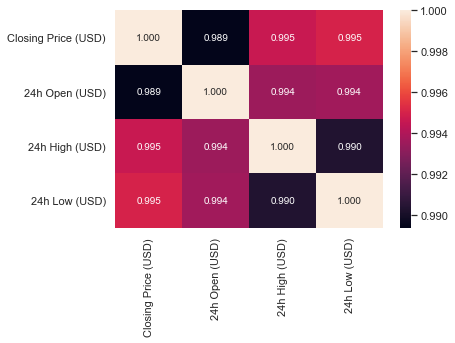

In [148]:
sns.heatmap(BTC.corr(), annot=True, fmt=".3f")   

* sns.jointplot(): Draw a plot of two variables with bivariate and univariate graphs.

<br>

```
Signature:
sns.jointplot(
    *,
    x=None,
    y=None,
    data=None,
    kind='scatter',
    color=None,
    height=6,
    ratio=5,
    space=0.2,
    dropna=False,
    xlim=None,
    ylim=None,
    marginal_ticks=False,
    joint_kws=None,
    marginal_kws=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    **kwargs,
)
Docstring:
Draw a plot of two variables with bivariate and univariate graphs.

This function provides a convenient interface to the :class:`JointGrid`
class, with several canned plot kinds. This is intended to be a fairly
lightweight wrapper; if you need more flexibility, you should use
:class:`JointGrid` directly.

Parameters
----------
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
kind : { "scatter" | "kde" | "hist" | "hex" | "reg" | "resid" }
    Kind of plot to draw. See the examples for references to the underlying functions.
color : :mod:`matplotlib color <matplotlib.colors>`
    Single color specification for when hue mapping is not used. Otherwise, the
    plot will try to hook into the matplotlib property cycle.
height : numeric
    Size of the figure (it will be square).
ratio : numeric
    Ratio of joint axes height to marginal axes height.
space : numeric
    Space between the joint and marginal axes
dropna : bool
    If True, remove observations that are missing from ``x`` and ``y``.
{x, y}lim : pairs of numbers
    Axis limits to set before plotting.
marginal_ticks : bool
    If False, suppress ticks on the count/density axis of the marginal plots.
{joint, marginal}_kws : dicts
    Additional keyword arguments for the plot components.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color of plot elements.
    Semantic variable that is mapped to determine the color of plot elements.
palette : string, list, dict, or :class:`matplotlib.colors.Colormap`
    Method for choosing the colors to use when mapping the ``hue`` semantic.
    String values are passed to :func:`color_palette`. List or dict values
    imply categorical mapping, while a colormap object implies numeric mapping.
hue_order : vector of strings
    Specify the order of processing and plotting for categorical levels of the
    ``hue`` semantic.
hue_norm : tuple or :class:`matplotlib.colors.Normalize`
    Either a pair of values that set the normalization range in data units
    or an object that will map from data units into a [0, 1] interval. Usage
    implies numeric mapping.
kwargs
    Additional keyword arguments are passed to the function used to
    draw the plot on the joint Axes, superseding items in the
    ``joint_kws`` dictionary.

Returns
-------
:class:`JointGrid`
    An object managing multiple subplots that correspond to joint and marginal axes
    for plotting a bivariate relationship or distribution.

See Also
--------
JointGrid : Set up a figure with joint and marginal views on bivariate data.
PairGrid : Set up a figure with joint and marginal views on multiple variables.
jointplot : Draw multiple bivariate plots with univariate marginal distributions.

Examples
--------

.. include:: ../docstrings/jointplot.rst
File:      c:\programdata\anaconda3\lib\site-packages\seaborn\axisgrid.py
Type:      function
```

<br>

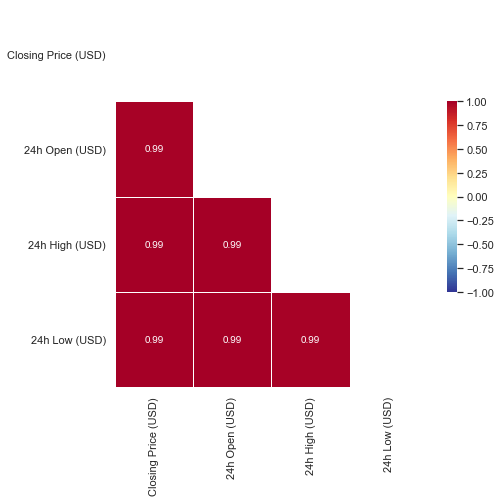

In [150]:
fig, ax = plt.subplots(figsize=(7,7))

# 삼각형 마스크를 만듬(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(BTC.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그림
sns.heatmap(BTC.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시함
            mask=mask,      # 표시하지 않을 마스크 부분을 지정함
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

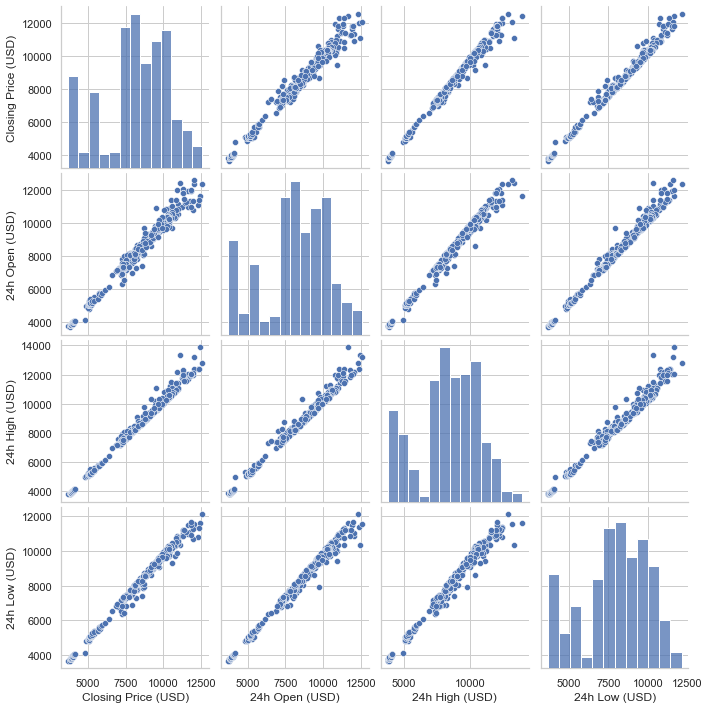

In [151]:
sns.pairplot(BTC)#산정도 행렬
plt.show()

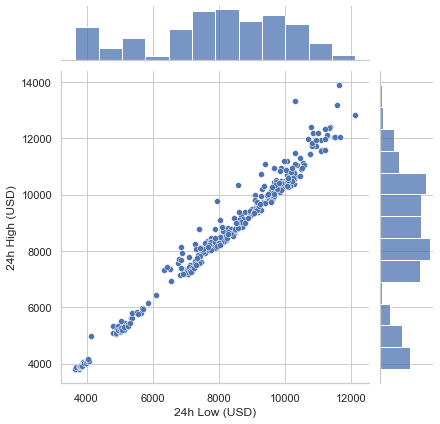

In [133]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'])

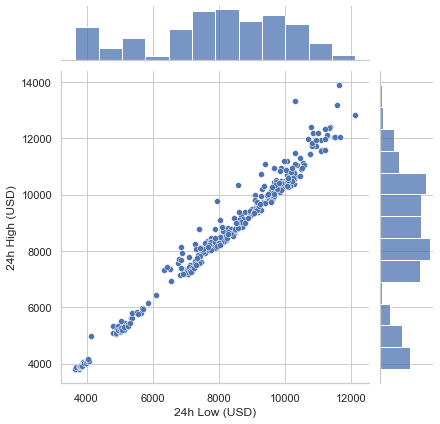

In [139]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='scatter')

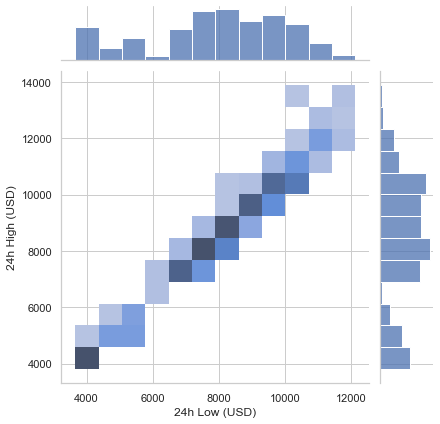

In [140]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='hist')

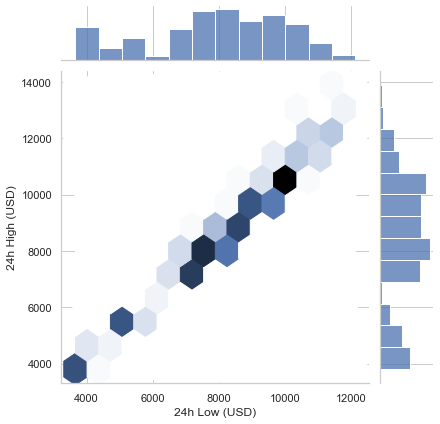

In [134]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='hex')

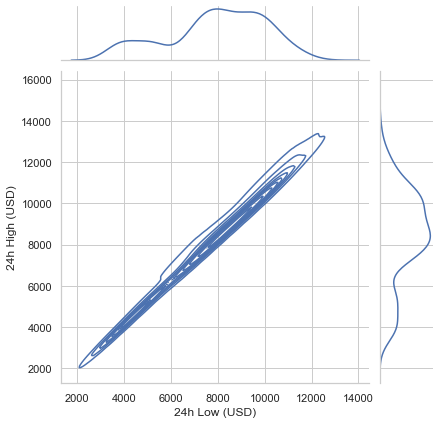

In [137]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='kde')

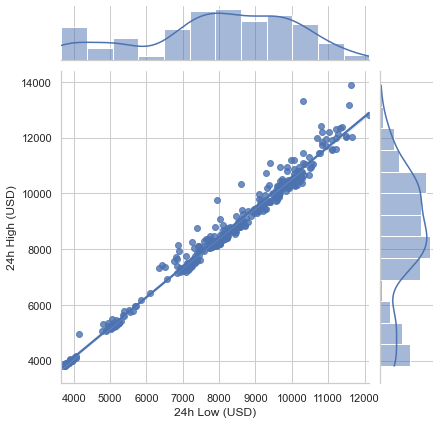

In [135]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='
              
              
              
              ')

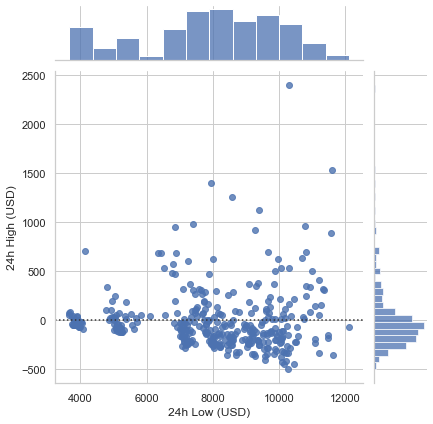

In [136]:
sns.jointplot(x=BTC['24h Low (USD)'], y=BTC['24h High (USD)'], kind='resid')

### 프로그램 8-1(b): 1년치 비트코인 가격 데이터를 윈도우로 자르기

In [141]:
# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=7 # 윈도우 크기
h=1 # 수평선 계수

X,Y = seq2dataset(seq,w,h)
print(X.shape,Y.shape)
print(X[0],Y[0]); print(X[-1],Y[-1])

(358, 7, 1) (358, 1)
[[3772.93633533]
 [3799.67854295]
 [3811.61197937]
 [3804.41917011]
 [3782.66410112]
 [3689.86289319]
 [3832.08088473]] [3848.95636968]
[[9631.48494596]
 [9670.85865437]
 [9689.08674285]
 [9919.55144784]
 [9640.46950506]
 [9392.86962872]
 [8787.97836316]] [8784.99535244]


<br>

## 8.3 LSTM으로 시계열 예측하기

### 8.3.1 단일 채널 비트코인 가격 예측

### 프로그램 8-2: LSTM을 이용한 비트코인 가격 예측

Epoch 1/200
250/250 - 6s - loss: 1707.2715 - mae: 1707.2715 - val_loss: 463.9105 - val_mae: 463.9105 - 6s/epoch - 24ms/step
Epoch 2/200
250/250 - 4s - loss: 540.5914 - mae: 540.5914 - val_loss: 450.3665 - val_mae: 450.3665 - 4s/epoch - 15ms/step
Epoch 3/200
250/250 - 3s - loss: 511.0166 - mae: 511.0166 - val_loss: 359.8917 - val_mae: 359.8917 - 3s/epoch - 13ms/step
Epoch 4/200
250/250 - 3s - loss: 488.4354 - mae: 488.4354 - val_loss: 328.1004 - val_mae: 328.1004 - 3s/epoch - 13ms/step
Epoch 5/200
250/250 - 4s - loss: 521.4319 - mae: 521.4319 - val_loss: 294.3073 - val_mae: 294.3073 - 4s/epoch - 16ms/step
Epoch 6/200
250/250 - 4s - loss: 468.1478 - mae: 468.1478 - val_loss: 703.6819 - val_mae: 703.6819 - 4s/epoch - 17ms/step
Epoch 7/200
250/250 - 4s - loss: 485.2543 - mae: 485.2543 - val_loss: 284.2502 - val_mae: 284.2502 - 4s/epoch - 15ms/step
Epoch 8/200
250/250 - 4s - loss: 612.7691 - mae: 612.7691 - val_loss: 329.5145 - val_mae: 329.5145 - 4s/epoch - 17ms/step
Epoch 9/200
250/250 - 

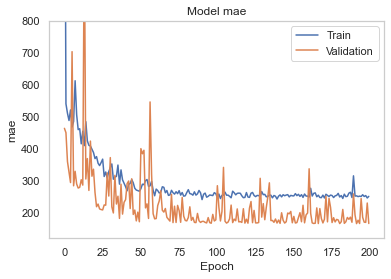

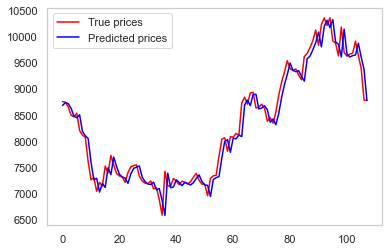

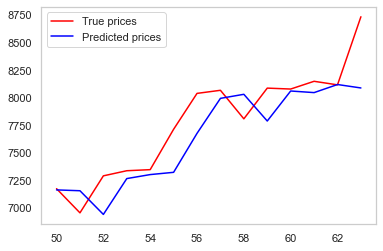

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 다운로드한 1년치 비트코인 가격 데이터 읽기
f=open('D:/00000000000000000000000000000000000000000000000 2022년 고교 서머스쿨/ch8/BTC_USD_2019-02-28_2020-02-27-CoinDesk.csv','r')
coindesk_data=pd.read_csv(f,header=0)
seq=coindesk_data[['Closing Price (USD)']].to_numpy() # 종가만 취함

# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=7 # 윈도우 크기
h=1 # 수평선 계수

X,Y=seq2dataset(seq,w,h)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 훈련 집합과 테스트 집합으로 분할
split=int(len(X)*0.7)
x_train=X[0:split]; y_train=Y[0:split]
x_test=X[split:]; y_test=Y[split:]

# LSTM 모델 설계와 학습
model=Sequential()
model.add(LSTM(units=128,activation='relu',input_shape=x_train[0].shape))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam',metrics=['mae'])
hist=model.fit(x_train,y_train,epochs=200,batch_size=1,validation_data=(x_test,y_test),verbose=2)

# LSTM 모델 평가
ev=model.evaluate(x_test,y_test,verbose=0)
print("손실 함수:",ev[0],"MAE:",ev[1])

# LSTM 모델로 예측 수행
pred=model.predict(x_test)
print("평균절댓값백분율오차(MAPE):",sum(abs(y_test-pred)/y_test)/len(x_test))

# 학습 곡선
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.ylim([120,800])
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

# 예측 결과 시각화
x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range], color='red')
plt.plot(x_range,pred[x_range], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

# 일부 구간을 확대하여 시각화
x_range=range(50,64)
plt.plot(x_range,y_test[x_range], color='red')
plt.plot(x_range,pred[x_range], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

<br>

### 8.3.3 다중 채널 비트코인 가격 예측

### 프로그램 8-3: 다중 채널 비트코인 가격 예측

(358, 7, 4) (358, 4)
[[3772.93633533 3796.63728431 3824.16587937 3666.52401643]
 [3799.67854295 3773.44146075 3879.23118467 3753.80002246]
 [3811.61197937 3799.36702601 3840.04482307 3788.91849833]
 [3804.41917011 3806.69151279 3819.19435612 3759.40921647]
 [3782.66410112 3807.84575592 3818.69548135 3766.24204823]
 [3689.86289319 3783.35506344 3804.35361623 3663.47774336]
 [3832.08088473 3701.04987103 3866.71870424 3688.69715385]] [3848.95636968 3832.59242908 3881.96576977 3802.51605364]
Epoch 1/200
250/250 - 4s - loss: 1655.4266 - mae: 1655.4266 - val_loss: 382.9615 - val_mae: 382.9615 - 4s/epoch - 17ms/step
Epoch 2/200
250/250 - 3s - loss: 600.2872 - mae: 600.2872 - val_loss: 756.1222 - val_mae: 756.1222 - 3s/epoch - 12ms/step
Epoch 3/200
250/250 - 3s - loss: 641.6038 - mae: 641.6038 - val_loss: 399.8264 - val_mae: 399.8264 - 3s/epoch - 14ms/step
Epoch 4/200
250/250 - 4s - loss: 499.4243 - mae: 499.4243 - val_loss: 335.0106 - val_mae: 335.0106 - 4s/epoch - 15ms/step
Epoch 5/200
250/2

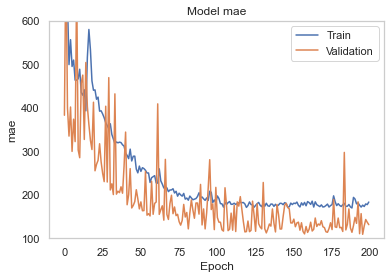

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 1년치 비트코인 가격 데이터 읽기
f=open('D:/00000000000000000000000000000000000000000000000 2022년 고교 서머스쿨/ch8/BTC_USD_2019-02-28_2020-02-27-CoinDesk.csv','r')
coindesk_data=pd.read_csv(f,header=0)
seq=coindesk_data[['Closing Price (USD)','24h Open (USD)','24h High (USD)','24h Low (USD)']].to_numpy() # 종가, 시가, 고가, 저가를 모두 취함

# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=7 # 윈도우 크기
h=1 # 수평선 계수

X,Y = seq2dataset(seq,w,h)
print(X.shape,Y.shape)
print(X[0],Y[0])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 훈련 집합과 테스트 집합으로 분할
split=int(len(X)*0.7)
x_train=X[0:split]; y_train=Y[0:split]
x_test=X[split:]; y_test=Y[split:]

# LSTM 모델의 설계와 학습
model = Sequential()
model.add(LSTM(units=128,activation='relu',input_shape=x_train[0].shape))
model.add(Dense(4))
model.compile(loss='mae',optimizer='adam',metrics=['mae'])
hist=model.fit(x_train,y_train,epochs=200,batch_size=1,validation_data=(x_test,y_test),verbose=2)

# LSTM 모델 평가
ev=model.evaluate(x_test,y_test,verbose=0)
print("손실 함수:",ev[0],"MAE:",ev[1])

# LSTM 모델로 예측 수행
pred=model.predict(x_test) # LSTM
print("LSTM 평균절댓값백분율오차(MAPE):",sum(abs(y_test-pred)/y_test)/len(x_test))

# 학습 곡선
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.ylim([100,600])
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

In [159]:
y_test

array([[ 8760.89271814,  8711.536153  ,  8856.3815562 ,  8564.93793345],
       [ 8749.52059102,  8760.88854638,  8837.92125152,  8703.63544987],
       [ 8656.97092235,  8758.54664197,  8785.05419945,  8562.3745933 ],
       [ 8500.64355816,  8656.97185832,  8763.90347224,  8359.84919159],
       [ 8469.2608989 ,  8500.64393561,  8539.13217376,  8423.54320524],
       [ 8537.33965197,  8469.26101453,  8624.95630521,  8369.22496288],
       [ 8205.80636599,  8500.64460295,  8500.64648931,  8035.88590703],
       [ 8118.4885358 ,  8205.81004333,  8205.81004333,  7988.92262849],
       [ 8074.84317361,  8119.48444399,  8215.61958867,  8029.0977271 ],
       [ 7612.7405735 ,  8074.84056122,  8118.11399559,  7420.28132157],
       [ 7262.11053495,  7618.5794133 ,  7717.80208765,  6804.14306494],
       [ 7303.40575852,  7262.12793424,  7354.8626346 ,  7094.97579095],
       [ 7041.73293642,  7303.41426515,  7338.69867732,  6920.63149703],
       [ 7211.86180875,  6894.65135448,  7368.14738

In [160]:
y_test.shape

(108, 4)

In [161]:
# 테스트 데이터 중 종가
y_test.T[0]

array([ 8760.89271814,  8749.52059102,  8656.97092235,  8500.64355816,
        8469.2608989 ,  8537.33965197,  8205.80636599,  8118.4885358 ,
        8074.84317361,  7612.7405735 ,  7262.11053495,  7303.40575852,
        7041.73293642,  7211.86180875,  7141.06944869,  7523.4806726 ,
        7390.20746923,  7729.26593894,  7542.23560864,  7381.96300782,
        7333.43293049,  7315.36776456,  7213.73376172,  7398.78704961,
        7511.88058312,  7532.12351309,  7550.23919987,  7333.09604316,
        7239.76257544,  7198.06667705,  7190.27236926,  7238.87432299,
        7087.02498535,  7112.73147612,  6883.49639377,  6584.02884335,
        7424.01540023,  7147.56832379,  7139.93337053,  7286.33508116,
        7236.98620461,  7166.17237853,  7235.6266505 ,  7212.80939522,
        7183.70653603,  7227.29371168,  7311.56064392,  7385.46484791,
        7251.27679432,  7179.95781929,  7174.74401195,  6955.48757967,
        7291.21950532,  7337.63667014,  7347.43326444,  7713.86075365,
      

In [162]:
# 테스트 데이터 시가
y_test.T[1]

array([ 8711.536153  ,  8760.88854638,  8758.54664197,  8656.97185832,
        8500.64393561,  8469.26101453,  8500.64460295,  8205.81004333,
        8119.48444399,  8074.84056122,  7618.5794133 ,  7262.12793424,
        7303.41426515,  6894.65135448,  7211.87098271,  7141.07550853,
        7523.47288668,  7390.21065617,  7748.33548684,  7542.2453443 ,
        7381.96200503,  7315.43920337,  7315.36927448,  7213.74341597,
        7392.9109373 ,  7511.88460514,  7532.12351304,  7550.23881523,
        7333.0958889 ,  7240.07822702,  7203.95660632,  7188.07189512,
        7238.99308949,  7087.02495776,  7112.50497677,  6884.66155356,
        6584.03042422,  7285.1220445 ,  7147.569001  ,  7155.21317455,
        7286.33631015,  7236.98608629,  7166.17304518,  7235.62358159,
        7212.80836135,  7183.7060826 ,  7227.29438829,  7315.15154817,
        7379.15788121,  7251.27788754,  7179.95768862,  7174.71235654,
        6955.48757967,  7291.2175036 ,  7337.42139068,  7351.57888987,
      

In [163]:
# 테스트 데이터 고가
y_test.T[2]

array([ 8856.3815562 ,  8837.92125152,  8785.05419945,  8763.90347224,
        8539.13217376,  8624.95630521,  8500.64648931,  8205.81004333,
        8215.61958867,  8118.11399559,  7717.80208765,  7354.8626346 ,
        7338.69867732,  7368.147389  ,  7336.30101028,  7660.64037047,
        7647.51808885,  7856.60790553,  7805.02932238,  7564.94007919,
        7440.61573641,  7407.41077474,  7767.90872485,  7488.13777162,
        7583.38745566,  7619.66601783,  7573.15601763,  7652.74260617,
        7394.50467576,  7269.47439125,  7282.33614277,  7297.58889434,
        7271.57118428,  7198.32383975,  7139.58024337,  6933.74117938,
        7424.06402963,  7367.15885611,  7177.39215106,  7328.9308126 ,
        7356.64051914,  7498.79730446,  7292.00673583,  7277.80411105,
        7427.47228016,  7251.38124578,  7348.78979432,  7520.63703409,
        7396.6033218 ,  7298.89204162,  7237.01486597,  7190.18874928,
        7390.04183506,  7390.76293533,  7487.33387079,  7749.6486133 ,
      

In [164]:
# 테스트 데이터 저가
y_test.T[3]

array([ 8564.93793345,  8703.63544987,  8562.3745933 ,  8359.84919159,
        8423.54320524,  8369.22496288,  8035.88590703,  7988.92262849,
        8029.0977271 ,  7420.28132157,  6804.14306494,  7094.97579095,
        6920.63149703,  6524.5528585 ,  7012.05770202,  6851.62292978,
        7379.30991765,  7378.40554326,  7439.09886715,  7238.32223251,
        7162.49212483,  7238.73059179,  7089.14128889,  7155.1199462 ,
        7304.07044092,  7475.01559399,  7387.15401587,  7285.22776774,
        7161.52729088,  7131.64405445,  7081.88022052,  7183.20175448,
        7007.42692286,  7007.558814  ,  6828.47944833,  6565.00964459,
        6427.95938645,  7043.16224946,  7076.11104036,  7122.02423349,
        7083.7347261 ,  7127.93625472,  7045.12291457,  7120.21395008,
        7105.72386359,  7065.27830843,  7217.0795968 ,  7272.59379078,
        7202.13076589,  7119.62694587,  7152.99240213,  6914.8574738 ,
        6852.09340145,  7263.17869561,  7316.76337026,  7339.70252309,
      

In [165]:
pred

array([[ 8753.362 ,  8794.633 ,  8916.528 ,  8499.532 ],
       [ 8803.694 ,  8846.796 ,  8977.004 ,  8549.036 ],
       [ 8820.469 ,  8863.054 ,  8993.937 ,  8569.956 ],
       [ 8694.183 ,  8734.303 ,  8857.117 ,  8449.45  ],
       [ 8564.838 ,  8605.062 ,  8725.337 ,  8318.09  ],
       [ 8526.451 ,  8566.172 ,  8686.666 ,  8281.444 ],
       [ 8588.914 ,  8627.709 ,  8752.118 ,  8355.06  ],
       [ 8221.846 ,  8259.582 ,  8368.828 ,  7978.029 ],
       [ 8160.8755,  8198.511 ,  8309.1   ,  7919.569 ],
       [ 8155.168 ,  8192.564 ,  8306.902 ,  7921.8047],
       [ 7649.3525,  7683.467 ,  7776.258 ,  7411.888 ],
       [ 7264.132 ,  7296.6035,  7381.621 ,  7027.699 ],
       [ 7353.092 ,  7387.1196,  7487.043 ,  7128.827 ],
       [ 7080.6724,  7113.432 ,  7206.6753,  6864.59  ],
       [ 7161.7534,  7194.1475,  7301.2935,  6963.3057],
       [ 7203.0713,  7240.687 ,  7356.3994,  6995.285 ],
       [ 7504.047 ,  7540.7983,  7669.2817,  7312.2905],
       [ 7461.122 ,  7502.381 ,

In [166]:
pred.shape

(108, 4)

In [167]:
# 예측 데이터 중 종가
pred.T[0]

array([ 8753.362 ,  8803.694 ,  8820.469 ,  8694.183 ,  8564.838 ,
        8526.451 ,  8588.914 ,  8221.846 ,  8160.8755,  8155.168 ,
        7649.3525,  7264.132 ,  7353.092 ,  7080.6724,  7161.7534,
        7203.0713,  7504.047 ,  7461.122 ,  7771.899 ,  7570.461 ,
        7400.117 ,  7369.0625,  7370.6724,  7360.0415,  7416.9146,
        7544.6284,  7581.5303,  7553.8394,  7413.2554,  7283.7324,
        7245.3325,  7235.9097,  7295.225 ,  7122.398 ,  7163.322 ,
        6936.1987,  6659.358 ,  7353.421 ,  7169.3066,  7163.3994,
        7334.3774,  7251.2666,  7282.927 ,  7238.905 ,  7250.564 ,
        7272.12  ,  7229.7256,  7369.3105,  7443.0254,  7279.595 ,
        7233.6997,  7233.2314,  7006.858 ,  7335.0513,  7372.547 ,
        7411.8037,  7737.674 ,  8101.595 ,  8145.912 ,  7813.8804,
        8120.4   ,  8162.078 ,  8151.4995,  8157.985 ,  8796.703 ,
        8828.13  ,  8726.021 ,  8985.849 ,  8948.905 ,  8736.381 ,
        8685.349 ,  8753.202 ,  8698.491 ,  8424.3545,  8485.6

In [168]:
# 예측 데이터 중 시가
pred.T[1]

array([ 8794.633 ,  8846.796 ,  8863.054 ,  8734.303 ,  8605.062 ,
        8566.172 ,  8627.709 ,  8259.582 ,  8198.511 ,  8192.564 ,
        7683.467 ,  7296.6035,  7387.1196,  7113.432 ,  7194.1475,
        7240.687 ,  7540.7983,  7502.381 ,  7811.5444,  7609.1   ,
        7438.1216,  7403.148 ,  7405.441 ,  7394.18  ,  7452.1763,
        7580.827 ,  7618.61  ,  7590.0156,  7448.116 ,  7316.8794,
        7277.4985,  7268.3516,  7328.7065,  7155.7324,  7196.488 ,
        6967.833 ,  6688.6885,  7387.4385,  7204.9536,  7200.8506,
        7373.3726,  7286.8633,  7317.165 ,  7274.7886,  7283.9546,
        7305.85  ,  7262.7017,  7403.687 ,  7478.1577,  7313.7627,
        7267.2495,  7265.668 ,  7037.6904,  7367.4844,  7407.669 ,
        7447.7725,  7775.72  ,  8141.2188,  8186.825 ,  7853.865 ,
        8159.506 ,  8202.78  ,  8190.872 ,  8199.616 ,  8838.713 ,
        8871.539 ,  8771.202 ,  9031.384 ,  8993.231 ,  8778.234 ,
        8727.303 ,  8793.256 ,  8738.628 ,  8464.822 ,  8524.7

In [169]:
# 예측 데이터 중 고가
pred.T[2]

array([ 8916.528 ,  8977.004 ,  8993.937 ,  8857.117 ,  8725.337 ,
        8686.666 ,  8752.118 ,  8368.828 ,  8309.1   ,  8306.902 ,
        7776.258 ,  7381.621 ,  7487.043 ,  7206.6753,  7301.2935,
        7356.3994,  7669.2817,  7630.9087,  7945.175 ,  7727.348 ,
        7547.3457,  7506.8486,  7513.54  ,  7501.744 ,  7566.3145,
        7699.929 ,  7737.0854,  7704.04  ,  7552.4204,  7415.9297,
        7376.443 ,  7370.627 ,  7436.3735,  7256.148 ,  7299.9883,
        7060.829 ,  6769.582 ,  7509.3594,  7316.3584,  7313.6816,
        7496.9673,  7398.388 ,  7425.3706,  7385.944 ,  7389.3623,
        7412.985 ,  7367.4653,  7515.8916,  7593.344 ,  7417.968 ,
        7368.7266,  7367.37  ,  7128.8555,  7480.245 ,  7523.66  ,
        7562.4717,  7907.2095,  8283.087 ,  8322.841 ,  7968.745 ,
        8287.302 ,  8332.552 ,  8316.162 ,  8327.912 ,  8993.323 ,
        9018.999 ,  8909.332 ,  9178.814 ,  9133.482 ,  8902.729 ,
        8853.606 ,  8920.873 ,  8864.52  ,  8581.877 ,  8645.7

In [170]:
# 예측 데이터 중 저가
pred.T[3]

array([ 8499.532 ,  8549.036 ,  8569.956 ,  8449.45  ,  8318.09  ,
        8281.444 ,  8355.06  ,  7978.029 ,  7919.569 ,  7921.8047,
        7411.888 ,  7027.699 ,  7128.827 ,  6864.59  ,  6963.3057,
        6995.285 ,  7312.2905,  7255.7627,  7570.5293,  7358.3755,
        7178.4526,  7158.5864,  7163.515 ,  7156.8315,  7213.1094,
        7342.7676,  7375.938 ,  7345.872 ,  7199.854 ,  7072.6113,
        7039.788 ,  7034.9478,  7096.8037,  6917.4565,  6962.3604,
        6732.8755,  6454.158 ,  7167.512 ,  6968.1616,  6957.1626,
        7132.1226,  7049.785 ,  7085.3716,  7033.734 ,  7050.366 ,
        7073.023 ,  7029.932 ,  7172.3354,  7245.6924,  7073.7236,
        7026.669 ,  7032.041 ,  6803.3193,  7145.7656,  7177.386 ,
        7210.813 ,  7542.4424,  7906.664 ,  7936.7925,  7580.9   ,
        7900.39  ,  7942.629 ,  7930.882 ,  7929.862 ,  8588.388 ,
        8606.328 ,  8481.646 ,  8745.618 ,  8705.271 ,  8486.115 ,
        8433.95  ,  8511.995 ,  8458.784 ,  8174.255 ,  8244.3

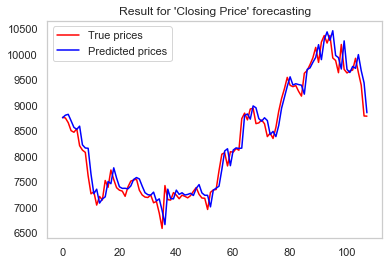

In [173]:
# 종가 예측 결과 시각화
x_range=range(len(y_test.T[0]))
plt.plot(x_range,y_test.T[0][x_range], color='red')
plt.plot(x_range,pred.T[0][x_range], color='blue')
plt.title("Result for 'Closing Price' forecasting")
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

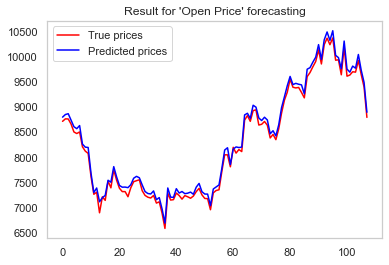

In [174]:
# 시가 예측 결과 시각화
x_range=range(len(y_test.T[1]))
plt.plot(x_range,y_test.T[1][x_range], color='red')
plt.plot(x_range,pred.T[1][x_range], color='blue')
plt.title("Result for 'Open Price' forecasting")
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

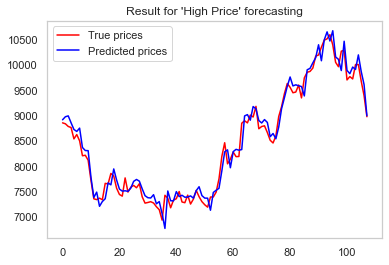

In [175]:
# 고가 예측 결과 시각화
x_range=range(len(y_test.T[2]))
plt.plot(x_range,y_test.T[2][x_range], color='red')
plt.plot(x_range,pred.T[2][x_range], color='blue')
plt.title("Result for 'High Price' forecasting")
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

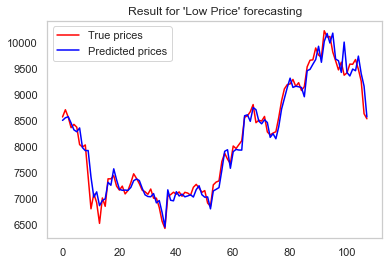

In [176]:
# 저가 예측 결과 시각화
x_range=range(len(y_test.T[3]))
plt.plot(x_range,y_test.T[3][x_range], color='red')
plt.plot(x_range,pred.T[3][x_range], color='blue')
plt.title("Result for 'Low Price' forecasting")
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

<br>